<a href="https://colab.research.google.com/github/ByronHsu/ds-100-final/blob/master/AQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os
colab_env = False
# Detect environment
if 'google.colab' in sys.modules:
    print('Colab is detected')
    project_path = '/content/Data_C200_Final_Project_Part_2'
    if not os.path.exists(project_path):
        os.mkdir(project_path)
    os.chdir(project_path)
    !pip install gdown --quiet
    import gdown, zipfile
    # Download datasets used by this project
    if not os.path.exists('data'):
        print('\'data/\' does not exist')
        data_url = 'https://drive.google.com/u/1/uc?id=1QhryFoiUduLL0iuwdIJMyKrbb2RaX9L_'
        gdown.download(data_url, 'data.zip', False)
        with zipfile.ZipFile('data.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('data'): sys.exit('Cannot download source files')
    if not os.path.exists('images'):
        print('\'images/\' does not exist')
        images_url = 'https://drive.google.com/u/1/uc?id=1aHJ1hAx0-QiAOLLFQo2oUve2dRowfjL6'
        gdown.download(images_url, 'images.zip', False)
        with zipfile.ZipFile('images.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('images'): sys.exit('Cannot download source files')
    if not os.path.exists('tests'):
        print('\'tests/\' does not exist')
        tests_url = 'https://drive.google.com/u/1/uc?id=1sXm8m9q9pEG_6IMWSRjdOzcF9OrW3l9T'
        gdown.download(tests_url, 'tests.zip', False)
        with zipfile.ZipFile('tests.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall()
        if not os.path.exists('tests'): sys.exit('Cannot download source files')
    # Initialize Otter
    !pip install otter-grader --quiet
    import otter
    grader = otter.Notebook('AQI.ipynb')
    colab_env = True

if not colab_env:
    print('Running locally')
    # Initialize Otter
    import otter
    grader = otter.Notebook('AQI.ipynb')
    # Change the os directory to project root that contains 'test/' and 'data/' if needed
    # os.chdir('path/to/project/root')

Colab is detected
'data/' does not exist


Downloading...
From: https://drive.google.com/u/1/uc?id=1QhryFoiUduLL0iuwdIJMyKrbb2RaX9L_
To: /content/Data_C200_Final_Project_Part_2/data.zip
100%|██████████| 244M/244M [00:01<00:00, 211MB/s]


Extracting...
'images/' does not exist


Downloading...
From: https://drive.google.com/u/1/uc?id=1aHJ1hAx0-QiAOLLFQo2oUve2dRowfjL6
To: /content/Data_C200_Final_Project_Part_2/images.zip
100%|██████████| 163k/163k [00:00<00:00, 43.4MB/s]


Extracting...
'tests/' does not exist


Downloading...
From: https://drive.google.com/u/1/uc?id=1sXm8m9q9pEG_6IMWSRjdOzcF9OrW3l9T
To: /content/Data_C200_Final_Project_Part_2/tests.zip
100%|██████████| 6.75k/6.75k [00:00<00:00, 5.46MB/s]


Extracting...
     |████████████████████████████████| 179 kB 4.3 MB/s 
     |████████████████████████████████| 89 kB 7.0 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 10.1 MB 27.3 MB/s 


# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [ ]:
if colab_env:
    !pip install pygeos --quiet
    !pip install geopandas --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.axes._axes import _log as axes_logger
axes_logger.setLevel('ERROR')

import re, gc, os, warnings
warnings.filterwarnings('ignore')
import requests, io
import geopandas as gpd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.base import clone
from sklearn.model_selection import (
    train_test_split,
    KFold
)
from sklearn.metrics import log_loss

if colab_env:
    !pip install pytorch-lightning==1.2.4 --quiet
    !pip install pytorch-forecasting==0.9.0 --quiet
    !pip install torchmetrics==0.5.0 --quiet
    from pytorch_forecasting.data import (
        TimeSeriesDataSet,
        GroupNormalizer
    )
    import pytorch_lightning as pl
    from pytorch_lightning.callbacks import (
        EarlyStopping,
        LearningRateMonitor
    )
    from pytorch_lightning.loggers import TensorBoardLogger
    from pytorch_forecasting.models import TemporalFusionTransformer
    from pytorch_forecasting.metrics import (
        MAE,
        SMAPE,
        QuantileLoss
    )
    import torch
    import tensorflow as tf
    import tensorboard as tb
    tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

     |████████████████████████████████| 2.1 MB 4.4 MB/s 
     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 6.3 MB 45.5 MB/s 
     |████████████████████████████████| 15.4 MB 60 kB/s 
     |████████████████████████████████| 829 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 35.0 MB/s 
     |████████████████████████████████| 132 kB 56.0 MB/s 
     |████████████████████████████████| 829 kB 41.4 MB/s 
     |████████████████████████████████| 1.1 MB 34.4 MB/s 
     |████████████████████████████████| 192 kB 51.5 MB/s 
     |████████████████████████████████| 160 kB 54.8 MB/s 
     |████████████████████████████████| 271 kB 50.5 MB/s 
     |████████████████████████████████| 112 kB 4.3 MB/s 
     |████████████████████████████████| 308 kB 18.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 209 kB 51.6 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |███████████████

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [ ]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

name               epa_filename
0  annual_county_aqi  annual_aqi_by_county_2020
1   daily_county_aqi   daily_aqi_by_county_2020
2        daily_ozone           daily_44201_2020
3          daily_so2           daily_42401_2020
4           daily_co           daily_42101_2020
5          daily_no2           daily_42602_2020
6         daily_temp            daily_WIND_2020
7         daily_wind            daily_TEMP_2020
8          aqs_sites                  aqs_sites

Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [ ]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    print(name, filename)
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        print(path_name+' does not exist')
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

annual_county_aqi annual_aqi_by_county_2020
daily_county_aqi daily_aqi_by_county_2020
daily_ozone daily_44201_2020
daily_so2 daily_42401_2020
daily_co daily_42101_2020
daily_no2 daily_42602_2020
daily_temp daily_WIND_2020
daily_wind daily_TEMP_2020
aqs_sites aqs_sites


Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [ ]:
epa_data.get('annual_county_aqi').head()

State   County  Year  ...  Days SO2  Days PM2.5  Days PM10
0  Alabama  Baldwin  2020  ...         0          71          0
1  Alabama     Clay  2020  ...         0         108          0
2  Alabama   DeKalb  2020  ...         0          33          0
3  Alabama   Elmore  2020  ...         0           0          0
4  Alabama   Etowah  2020  ...         0          74          0

[5 rows x 19 columns]

<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

*ANS*:

Why would the 90th percentile AQI be useful as opposed to the maximum? 

The maximum value might be a outlier that is far from the rest of the data. The 90th percentile thus could be more representative of higher AQI values in the dataset, since the 90th percentile AQI is higher than 90% of the data. Max AQI levels could often be the AQI levels on extreme weather days, which are typically considered to be outliers in the data. 

What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

The difference between the 90th percentile AQI and Max AQI being larger than the difference between the 90th percentile AQI and the median AQI could indicate that maximum value is a outlier since it is very far from the median and inter quartile range of the data. Using the 90th percentile as an upper bound on the data would be a more accurate way of measuring the true spread and variability of the data.  

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [ ]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.DatetimeIndex(daily_county['Date']).month
daily_county['Day'] = pd.DatetimeIndex(daily_county['Date']).day

daily_county.head()

State Name county Name  State Code  ...  Number of Sites Reporting Month  Day
0    Alabama     Baldwin           1  ...                          1     1    1
1    Alabama     Baldwin           1  ...                          1     1    4
2    Alabama     Baldwin           1  ...                          1     1    7
3    Alabama     Baldwin           1  ...                          1     1   10
4    Alabama     Baldwin           1  ...                          1     1   13

[5 rows x 12 columns]

In [ ]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [ ]:
epa_data_CA = {}

for filename, df in epa_data.items():
    if "daily" not in filename: continue  # only extract daily data
    epa_data_CA[filename] = df[df["State Name"] == "California"]
    
epa_data_CA.get('daily_county_aqi').head()

State Name county Name  ...  Month  Day
14003  California     Alameda  ...      1    1
14004  California     Alameda  ...      1    2
14005  California     Alameda  ...      1    3
14006  California     Alameda  ...      1    4
14007  California     Alameda  ...      1    5

[5 rows x 12 columns]

In [ ]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [ ]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']

lambda_defining_site = lambda x: f"{x['State Code']}-{int(x['County Code']):03d}-{int(x['Site Number']):04d}"

lambda_defining_site_ca = lambda x: f"6_{int(x['County Code']):03d}"

def intro_location(df, level=''):
    if level == '':
        site_locations = epa_data.get('aqs_sites')[['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude']]
        site_locations['Defining Site'] = site_locations.apply(lambda_defining_site, axis=1)
        return df.merge(how="left", right = site_locations, on = ["Defining Site"])[cols]
    elif level == 'ca':
        # merge on county level for CA, used for modeling
        site_locations = epa_data.get('aqs_sites')[['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude', 'Elevation']]
        site_locations = site_locations[site_locations['State Code'] == '06']
        site_locations['state_county'] = site_locations.apply(lambda_defining_site_ca, axis=1)
        site_locations = site_locations.groupby('state_county')[['Latitude', 'Longitude', 'Elevation']].mean().reset_index()
        return df.merge(how="left", right = site_locations, on = ["state_county"])

epa_data_CA_merged = intro_location(epa_data_CA.get('daily_county_aqi'))
epa_data_CA_merged.head()

State Name county Name  Month  ...  Defining Site   Latitude   Longitude
0  California     Alameda      1  ...    06-001-0009  37.743065 -122.169935
1  California     Alameda      1  ...    06-001-0013  37.864767 -122.302741
2  California     Alameda      1  ...    06-001-0013  37.864767 -122.302741
3  California     Alameda      1  ...    06-001-0007  37.687526 -121.784217
4  California     Alameda      1  ...    06-001-0007  37.687526 -121.784217

[5 rows x 9 columns]

In [ ]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [ ]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")

# clean AADT invalid data
traffic_data["Back_AADT"] = traffic_data["Back_AADT"].str.replace(" ", "0")
traffic_data["Ahead_AADT"] = traffic_data["Ahead_AADT"].str.replace(" ", "0")
traffic_data["AADT"] = traffic_data["Back_AADT"].astype(int) + traffic_data["Ahead_AADT"].astype(int)

# clean long / lat invalid data
# latitude and longitude should be in the form of (int).(int) or -(int).(int)
traffic_data = traffic_data[traffic_data["Lon_S_or_W"].str.match(r"\d*\.\d*|-\d*\.\d*") & traffic_data["Lat_S_or_W"].str.match(r"\d*\.\d*|-\d*\.\d*")]
traffic_data["Longitude"] = traffic_data["Lon_S_or_W"].astype("float64")
traffic_data["Latitude"] = traffic_data["Lat_S_or_W"].astype("float64")

cols = ["District", "Route", "County", "Descriptn", "AADT", "Latitude", "Longitude"]
traffic_data_cleaned = traffic_data[cols]

traffic_data_cleaned.head()

District  Route County  ...  AADT   Latitude   Longitude
0         1      1    MEN  ...  4000  38.759843 -123.518503
1         1      1    MEN  ...  7100  38.770046 -123.531890
2         1      1    MEN  ...  6200  38.803549 -123.585411
3         1      1    MEN  ...  4600  38.903973 -123.691513
4         1      1    MEN  ...  5000  38.910913 -123.692410

[5 rows x 7 columns]

In [ ]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [ ]:
gpd_epa = gpd.GeoDataFrame(epa_data_CA_merged.copy(), geometry=gpd.points_from_xy(epa_data_CA_merged.Longitude, epa_data_CA_merged.Latitude))
gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned.copy(), geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))

cols = ["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", "Traffic Lat", "Traffic Long", "Descriptn", "AADT"]
gpd_epa_traffic = gpd.sjoin_nearest(gpd_epa, gpd_traffic)
gpd_epa_traffic = gpd_epa_traffic.rename(columns={"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", "Longitude_right": "Traffic Long"})
gpd_epa_traffic = gpd_epa_traffic[cols]

#not sure if we need the last line or not
gpd_epa_traffic.head()

State Name county Name  Month  ...  Traffic Long             Descriptn   AADT
0    California     Alameda      1  ...   -122.170586  OAKLAND, 98TH AVENUE  48300
24   California     Alameda      1  ...   -122.170586  OAKLAND, 98TH AVENUE  48300
184  California     Alameda      7  ...   -122.170586  OAKLAND, 98TH AVENUE  48300
185  California     Alameda      7  ...   -122.170586  OAKLAND, 98TH AVENUE  48300
186  California     Alameda      7  ...   -122.170586  OAKLAND, 98TH AVENUE  48300

[5 rows x 13 columns]

In [ ]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [ ]:
gb = epa_data["annual_county_aqi"][["State", "Max AQI", "Median AQI"]].groupby("State").mean().rename(columns={"Median AQI": "Average Median AQI", "Max AQI": "Average Max AQI"})

gb = gb[~gb.index.isin(["Country Of Mexico", "District Of Columbia", "Puerto Rico", "Virgin Islands"])]

worst_median_aqis = gb.sort_values("Average Median AQI", ascending = False)["Average Median AQI"][:10]
worst_max_aqis = gb.sort_values("Average Max AQI", ascending = False)["Average Max AQI"][:10]

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

print(worst_median_aqis.index & worst_max_aqis.index)
np.round(list(worst_max_aqis), 2)

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64
Index(['California', 'Arizona', 'Connecticut', 'Nevada'], dtype='object', name='State')


array([430.35, 334.42, 286.98, 238.23, 197.86, 196.67, 196.67, 137.42,
       133.  , 124.75])

In [ ]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

*ANS:*

States: 'California', 'Arizona', 'Connecticut', 'Nevada'

Those states are likely to suffer from wildfires, which cause them have both large number of relatively bad AQI days and days with extreme AQI values.

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [ ]:
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

gb = epa_data["annual_county_aqi"][["State", "Days with AQI"]].groupby("State").mean()
gb = gb[gb.index.isin(us_states)]

days_with_AQI = gb.sort_values("Days with AQI")["Days with AQI"]

days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [ ]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [ ]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data.set_index('County')['Days with AQI'].sort_values()
ca_aqi_days.head(20)

County
Del Norte          274
Trinity            331
Lake               351
Tuolumne           353
Amador             359
Plumas             360
Calaveras          364
Glenn              364
Napa               365
San Benito         366
San Diego          366
San Francisco      366
San Joaquin        366
San Luis Obispo    366
San Mateo          366
San Bernardino     366
Santa Barbara      366
Alameda            366
Santa Cruz         366
Sacramento         366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [ ]:
county_to_missing_dates = {}
ca_daily_county_aqi = epa_data_CA.get('daily_county_aqi')
all_days = pd.Series(ca_daily_county_aqi[ca_daily_county_aqi['county Name'] == "San Benito"]['Date'].values)
ca_counties_with_missing_aqi = ca_aqi_days[ca_aqi_days.values < 366].keys()
for county in ca_counties_with_missing_aqi:
    days_with_aqi = ca_daily_county_aqi[ca_daily_county_aqi['county Name'] == county]['Date'].values
    days_without_aqi = all_days[~all_days.isin(days_with_aqi)]
    county_to_missing_dates[county] = days_without_aqi.values
county_to_missing_dates

{'Amador': array(['2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
        '2020-08-24', '2020-10-17', '2020-10-18'], dtype=object),
 'Calaveras': array(['2020-06-04', '2020-09-21'], dtype=object),
 'Del Norte': array(['2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
        '2020-01-20', '2020-01-21', '2020-01-23', '2020-03-14',
        '2020-03-15', '2020-04-22', '2020-04-23', '2020-04-25',
        '2020-04-26', '2020-04-28', '2020-04-29', '2020-05-01',
        '2020-05-02', '2020-05-04', '2020-05-05', '2020-05-07',
        '2020-05-08', '2020-05-10', '2020-05-11', '2020-05-13',
        '2020-05-14', '2020-05-16', '2020-05-17', '2020-05-19',
        '2020-05-20', '2020-05-22', '2020-05-23', '2020-05-25',
        '2020-05-26', '2020-05-28', '2020-05-29', '2020-05-31',
        '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
        '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
        '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12',
        '2020-

In [ ]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

*ANS*

There does not seem to be any key missing dates in common between the counties that have missing AQI data. Del Norte and Trinity have the most missing days. These missing dates occur in blocks of days throughout the year which indicates that this may have happened due to equipment error and malfunctioning measurement instruments.  

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [ ]:
epa_daily_county_aqi = epa_data.get('daily_county_aqi')
# uncomment to filter only US states
# epa_daily_county_aqi = epa_daily_county_aqi[epa_daily_county_aqi['State Name'].isin(us_states)]
aqi_per_month = epa_daily_county_aqi.groupby('Month').mean()['AQI']
aqi_per_month_CA = epa_data_CA.get('daily_county_aqi').groupby('Month').mean()['AQI']

print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [ ]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

*ANS*

The average AQI in CA is relatively low in each month of the first half year, but the average AQI in October, September, and October, especially in September, are relatively high. A reason of this might be that AQI has some association with temperature which is relatively high during these months. Wildfires often begin during these months as well which might explain these high average AQI values.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

*ANS*

1. Same average AQI per year: a constant function
$$f(x) = \theta_0$$

2. A linear increase in the average AQI per year: a linear function with a slope term and an interceot term
$$g(x) = \theta_0 + \theta_1 \cdot x$$

### <!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [ ]:
# set endpoint's False to get the correct result, set True to pass tests
def bucket_data(table, aggfunc, resolution):
    my_table = table.copy()
    long_min = my_table['Longitude'].min()
    long_max = my_table['Longitude'].max()
    long_bucket = np.linspace(long_min, long_max, resolution, endpoint=False)
    my_table['long_bucket'] = pd.cut(my_table.Longitude,
                                     np.append(long_bucket - 0.00000001, 999),
                                     labels=np.around(long_bucket, decimals=2)
                                    )
    lat_min = my_table['Latitude'].min()
    lat_max = my_table['Latitude'].max()
    lat_bucket = np.linspace(lat_min, lat_max, resolution, endpoint=False)
    my_table['lat_bucket'] = pd.cut(my_table.Latitude,
                                    np.append(lat_bucket - 0.00000001, 999),
                                    labels=np.around(lat_bucket, decimals=2)
                                   )
    pvt_table = my_table.pivot_table(index=['lat_bucket'],
                                     columns=['long_bucket'], 
                                     values=['AQI'],
                                     aggfunc=aggfunc
                                    )
    return pvt_table

bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket     -124.2    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [ ]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

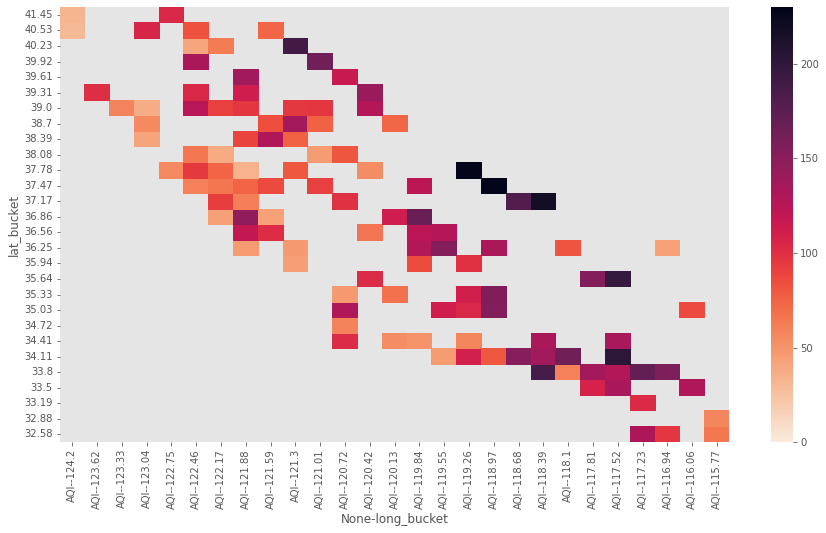

In [ ]:
heatmap_data = bucket_data(epa_data_CA_merged[epa_data_CA_merged['Month'] == 9], np.median, 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [ ]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

*ANS*

The dark regions correspond to areas with relatively high AQI values.This heatmap make sense because these dark regions can correspond to areas with relatively dense populations or relatively dry climates. Heavy traffic or wildfires in these areas might also be associated with these high average AQI values. 

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [ ]:
# Join CA counties Daily AQI with, ozone, so2, co, no2, temp, wind
epa_data_CA_aqi = epa_data_CA.get("daily_county_aqi").copy()
epa_data_CA_aqi["Site Num"] = epa_data_CA_aqi["Defining Site"].str.split("-").str[2].astype("int32")
epa_data_CA_aqi = epa_data_CA_aqi[["State Code", "County Code", "Site Num", "Date", "AQI"]]

for feature in ["ozone", "so2", "co", "no2", "temp", "wind"]:
    epa_data_CA_feature = epa_data_CA.get(f"daily_{feature}").copy().rename(columns={"Date Local": "Date", "Arithmetic Mean": f"{feature}"})
    epa_data_CA_feature = epa_data_CA_feature[["State Code", "County Code", "Site Num", "Date", f"{feature}"]]
    epa_data_CA_feature = epa_data_CA_feature.groupby(["State Code", "County Code", "Site Num", "Date"]).mean() # because there might be multiple data in a single date
    epa_data_CA_aqi = epa_data_CA_aqi.merge(
                        right = epa_data_CA_feature,
                        on = ["State Code", "County Code", "Site Num", "Date"]
                    )
# epa_data_CA_aqi.head()

# PCA CA counties Monthly Mean AQI
CA_aqi_monthly = pd.pivot_table(epa_data_CA_merged[['county Name', 'Month', 'AQI']],
                                values='AQI',
                                index='county Name',
                                columns='Month',
                                aggfunc='mean'
                               )
CA_aqi_monthly = CA_aqi_monthly.drop(index=['Del Norte'])
CA_aqi_monthly_standardized = (CA_aqi_monthly - np.mean(CA_aqi_monthly)) / np.std(CA_aqi_monthly)

u, s, vt = np.linalg.svd(CA_aqi_monthly_standardized, full_matrices = False)
CA_aqi_first_2_pcs = pd.DataFrame(CA_aqi_monthly_standardized @ vt[0:2].T) \
                                .reset_index()[[0, 1]].rename(columns = {0:'pc1', 1:'pc2'})
variance_explained = pd.Series(s**2 / sum(s**2), index=np.arange(1, 13))

# merge CA daily AQI with wind and temp
def clean_CA_daily_wind_temp(data):
    data = data[data['State Code'] == 6][['County Code', 'Arithmetic Mean', 'Date Local']]
    data = data.groupby(['County Code', 'Date Local']).mean().reset_index()
    data['Month'] = pd.DatetimeIndex(data['Date Local']).month
    data['Day'] = pd.DatetimeIndex(data['Date Local']).day
    return data

epa_CA_daily_temp = clean_CA_daily_wind_temp(epa_data.get('daily_wind')) \
                                .rename(columns={'Arithmetic Mean':'Mean Temp Degrees Fahrenheit'})
epa_CA_daily_wind = clean_CA_daily_wind_temp(epa_data.get('daily_temp')) \
                                .rename(columns={'Arithmetic Mean':'Mean Wind Speed Knot'})

cols_CA_7a_aqi_wind_temp = ['county Name', 'County Code', 'Month', 'Day', 'AQI']
epa_data_CA_merged_temp_wind = epa_data_CA_merged.copy()
epa_data_CA_merged_temp_wind['County Code'] = epa_data_CA_merged_temp_wind['Defining Site'].str.split('-').str[1].astype('int32')
epa_data_CA_merged_temp_wind = pd.merge(epa_data_CA_merged_temp_wind,
                                        epa_CA_daily_temp,
                                        how='inner',
                                        on=['County Code', 'Month', 'Day']
                                       )[np.append(cols_CA_7a_aqi_wind_temp, 'Mean Temp Degrees Fahrenheit')]
epa_data_CA_merged_temp_wind = pd.merge(epa_data_CA_merged_temp_wind,
                                        epa_CA_daily_wind,
                                        how='inner',
                                        on=['County Code', 'Month', 'Day']
                                       )[np.append(cols_CA_7a_aqi_wind_temp, ['Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot'])]
corr = pd.DataFrame(epa_data_CA_merged_temp_wind[['county Name', 'AQI', 'Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot']] \
                    .groupby('county Name').mean() \
                    .rename(columns={'Mean Temp Degrees Fahrenheit':'Temperature', 'Mean Wind Speed Knot':'Wind Speed'}) \
                    .corr())

# counties with highest annual median AQI
counties_highest_annual_median_AQI = epa_data_CA_merged.groupby('county Name')[['AQI']].median().sort_values('AQI', ascending=False)
epa_data_CA_merged_highest_10 = epa_data_CA_merged[epa_data_CA_merged['county Name'] \
                                                    .isin(counties_highest_annual_median_AQI.index[0:10])]

print("CA counties monthly mean AQI variance explained by each PC: \n{}\n".format(variance_explained))
print("CA counties annual mean AQI, temperature and wind speed correlation: \n{}\n".format(corr))
print("CA counties with highest annual median AQI: \n{}\n".format(counties_highest_annual_median_AQI.head(10)))

CA counties monthly mean AQI variance explained by each PC: 
1     0.646816
2     0.195906
3     0.078057
4     0.032231
5     0.015008
6     0.009794
7     0.007548
8     0.006891
9     0.003239
10    0.002240
11    0.001617
12    0.000653
dtype: float64

CA counties annual mean AQI, temperature and wind speed correlation: 
                  AQI  Temperature  Wind Speed
AQI          1.000000     0.262156    0.157837
Temperature  0.262156     1.000000    0.458807
Wind Speed   0.157837     0.458807    1.000000

CA counties with highest annual median AQI: 
                 AQI
county Name         
San Bernardino  93.0
Riverside       87.0
Los Angeles     83.0
Kern            81.0
Tulare          77.5
Fresno          74.0
San Diego       71.0
Kings           67.0
Madera          60.5
Imperial        58.0



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

<Figure size 540x540 with 0 Axes>

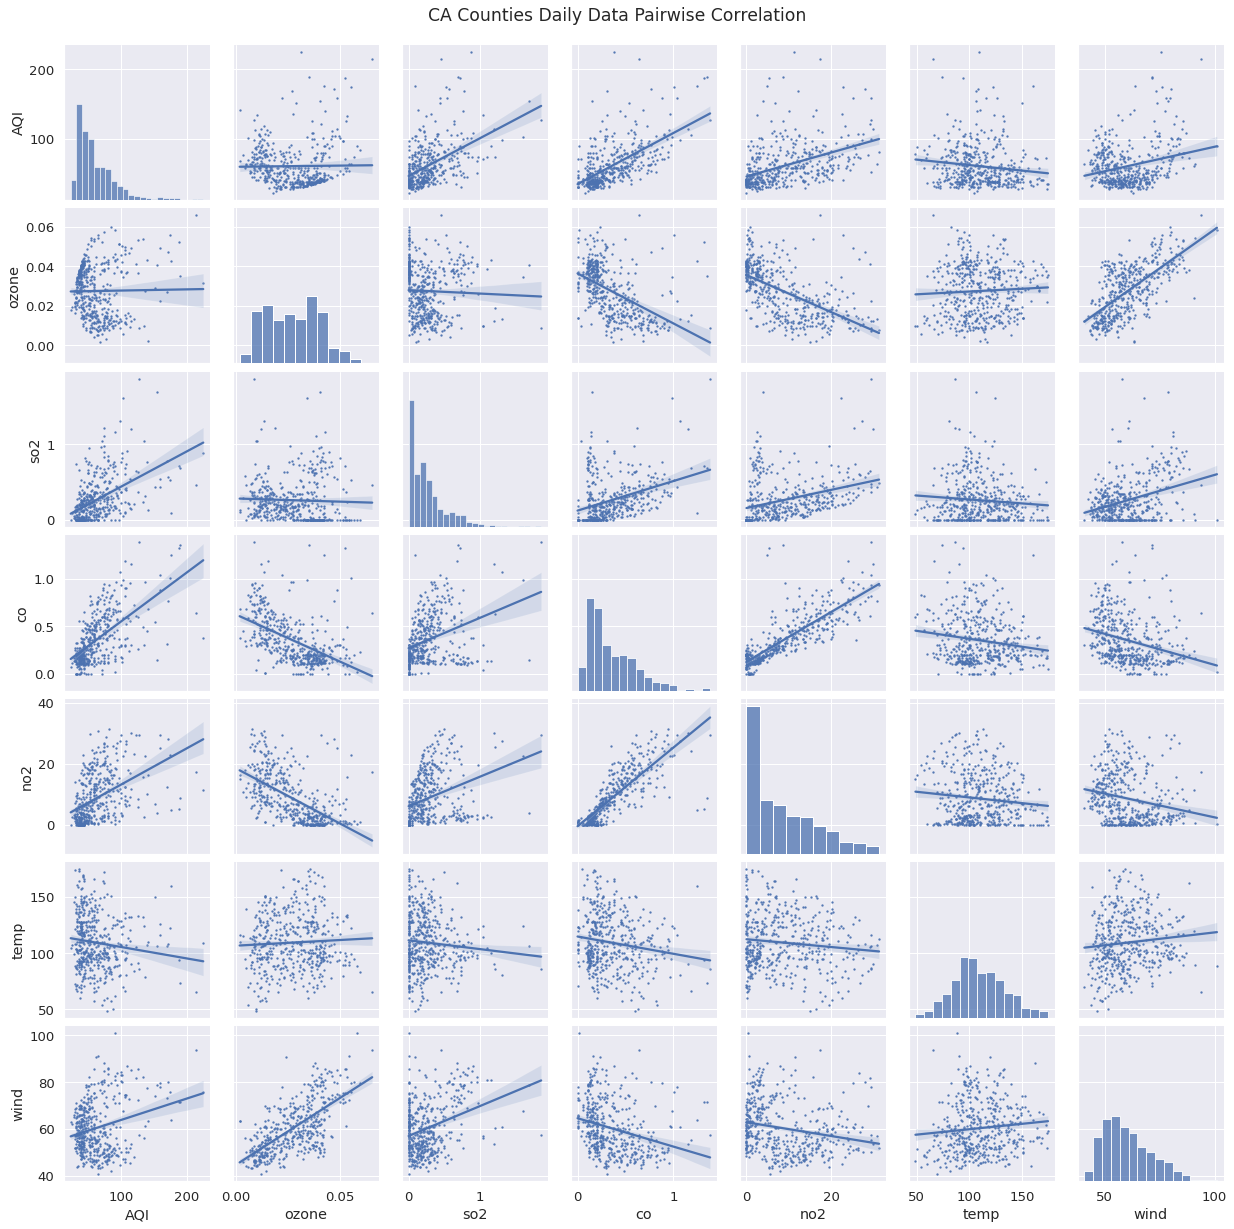

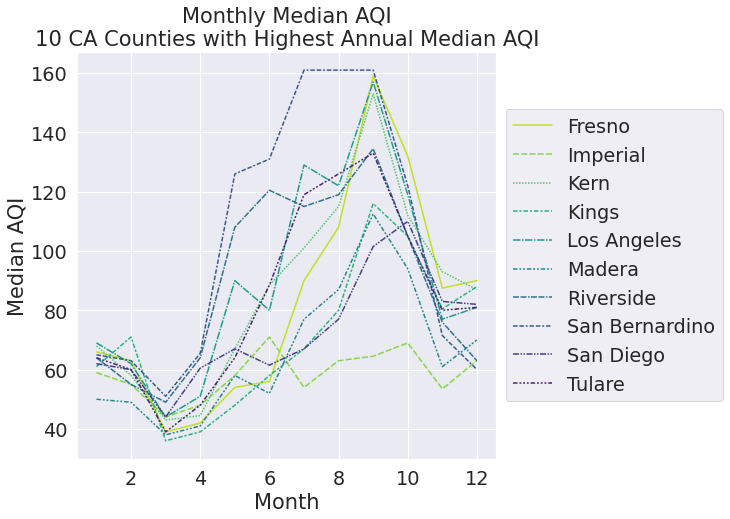

In [ ]:
# Visualization 1: CA Counties Daily Data Pairwise Correlation
plt.rcParams["figure.figsize"] = (7.5,7.5);
plt.figure();
sns.set(font_scale = 1.2);
pp = sns.pairplot(epa_data_CA_aqi,
                  vars=["AQI", "ozone", "so2", "co", "no2", "temp", "wind"],
                  palette='rocket',
                  kind="reg",
                  plot_kws={'scatter_kws':{'s':2}}
                 );
pp.fig.subplots_adjust(top=0.95);
pp.fig.suptitle('CA Counties Daily Data Pairwise Correlation');

# Visualization 2: Monthly Median AQI in CA Counties with Highest Annual Median AQI
plt.figure();
sns.set(font_scale = 1.75);
lp = sns.lineplot(data=epa_data_CA_merged_highest_10.groupby(['county Name', 'Month']).median(), 
                  x='Month', y='AQI',
                  hue='county Name', style='county Name',
                  palette='viridis_r'
                 );
lp.set_ylabel("Median AQI");
lp.set_title("Monthly Median AQI\n10 CA Counties with Highest Annual Median AQI");
lp.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show();

# Visualization 3: CA Counties Monthly Pct Air Pollution Days by Mean Temperature and Wind Speed
# air_pollution_days_categories = ['[0, 5%]', '(5%, 25%]', '(25%, 50%]', '(50%, 75%]', '(75%, 100%]']

# def categorize_pct_pollution_days(x):
#     if x['Pct Air Pollution Days'] <= 0.05: return air_pollution_days_categories[0]
#     if x['Pct Air Pollution Days'] <= 0.25: return air_pollution_days_categories[1]
#     if x['Pct Air Pollution Days'] <= 0.50: return air_pollution_days_categories[2]
#     if x['Pct Air Pollution Days'] <= 0.75: return air_pollution_days_categories[3]
#     return air_pollution_days_categories[4]

# def group_aqi_temp_wind_by_county(data):
#     data['Pct Air Pollution Days'] = data['AQI']
#     return data[['county Name', 'AQI', 'Pct Air Pollution Days', 'Mean Temp Degrees Fahrenheit', 'Mean Wind Speed Knot', 'Month']] \
#                 .groupby(['county Name', 'Month']) \
#                 .agg({'AQI': 'median',
#                       'Pct Air Pollution Days': lambda x: (x > 100.0).sum() / len(x),
#                       'Mean Temp Degrees Fahrenheit': 'mean',
#                       'Mean Wind Speed Knot': 'mean'
#                     }) \
#                 .reset_index()

# aqi_temp_wind_by_month_county = group_aqi_temp_wind_by_county(epa_data_CA_merged_temp_wind)
# aqi_temp_wind_by_month_county['Pct Air Pollution Days Category'] = \
#                 aqi_temp_wind_by_month_county.apply(categorize_pct_pollution_days, axis=1)
# sns.set(font_scale = 1.75);
# lp = sns.lmplot(data=aqi_temp_wind_by_month_county,
#                 x='Mean Temp Degrees Fahrenheit',
#                 y='Mean Wind Speed Knot',
#                 hue='Pct Air Pollution Days Category',
#                 hue_order=air_pollution_days_categories,
#                 palette='rocket_r',
#                 fit_reg=False,
#                 col='county Name',
#                 col_wrap=5,
#                 scatter_kws={"s": 50}
#                );
# lp.fig.subplots_adjust(top=0.95);
# lp.fig.suptitle('CA Counties Monthly Pct Air Pollution Days by Mean Temperature and Wind Speed');

# Visualization 4: CA Counties Monthly Mean AQI First Two PCs
# import plotly.express as px
# CA_aqi_first_2_pcs['county'] = list(CA_aqi_monthly_standardized.index)
# fig = px.scatter(CA_aqi_first_2_pcs,
#                  x='pc1', y='pc2',
#                  text='county',
#                  title='CA Counties Monthly Mean AQI First Two PCs',
#                  width=800, height=800
#                 );
# fig.update_traces(textposition='top center');
# fig.show();

# Further EDA with 5 years data
# five_year_df = pd.read_csv('data/data_extended/5_years.csv')
# aqi_ca = five_year_df[five_year_df['state_county'].str.contains(r"^6_.*")] \
#                 .reset_index().drop(['index'], axis=1)

# ca_filtered = aqi_ca[['Date', 'AQI', 'state_county']].copy()
# ca_filtered['month'] = pd.DatetimeIndex(ca_filtered['Date']).month
# ca_filtered['year'] = pd.DatetimeIndex(ca_filtered['Date']).year
# ca_filtered['week'] = pd.DatetimeIndex(ca_filtered['Date']).weekofyear
# ca_filtered['day of year'] = pd.DatetimeIndex(ca_filtered['Date']).dayofyear

# Visualization 5: CA AQI 5 year trend
# plt.figure(figsize=(18, 5), dpi=100);
# sns.set_style(style='white');
# lp = sns.lineplot(x=ca_filtered['Date'], y=ca_filtered['AQI'], linewidth=0.75, color='r');
# for ind, label in enumerate(lp.get_xticklabels()):
#     if ind % 100 == 0:
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
# plt.xticks(rotation=45);
# lp.set_ylim(20, 220);
# plt.title('California Counties AQI Trend 2016 - 2020');

# Visualize 6: CA AQI vs. shelter in place
# day_shelter_in_place = pd.Period('3-20-2020').dayofyear
# ca_filtered = ca_filtered[np.abs(ca_filtered['day of year'] - 30 - day_shelter_in_place) < 90]
# ca_filtered['shelter in place'] = ca_filtered['day of year'] >= day_shelter_in_place
# ca_19_20 = ca_filtered[ca_filtered['year'].isin([2019, 2020])]
# plt.figure(figsize=(18, 5), dpi=100)
# lp = sns.lineplot(x=ca_19_20['day of year'], y=ca_19_20['AQI'],
#                   hue=ca_19_20['year'].astype('str'),
#                   style=ca_19_20['shelter in place'],
#                   hue_order=['2020', '2019'],
#                   style_order=[True, False],
#                   linewidth=0.75
#                   );
# lp.set_ylim(20, 170);
# plt.axvline(x=80, linewidth=2, color=(0, 0, 0, 0.25));
# plt.title('California Counties Average AQI wrt. the Shelter in Place Order (day {})'.format(day_shelter_in_place));

# Visualization: 7 Los Angeles AQI vs. shelter in place
# sf_19_20 = ca_19_20[ca_19_20['state_county'] == '6_019']
# plt.figure(figsize=(18, 5), dpi=100)
# lp = sns.lineplot(x=sf_19_20['day of year'], y=sf_19_20['AQI'],
#                   hue=sf_19_20['year'].astype('str'),
#                   style=sf_19_20['shelter in place'],
#                   hue_order=['2020', '2019'],
#                   style_order=[True, False],
#                   linewidth=0.75
#                   );
# lp.set_ylim(20, 170);
# plt.axvline(x=80, linewidth=2, color=(0, 0, 0, 0.25));
# plt.title('Los Angeles AQI wrt. the Shelter in Place Order (day {})'.format(day_shelter_in_place));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

*ANS*

We first decided to analyze the concentrations of certain chemical compounds in the atmosphere to determine if a correlation can be seen between the concentration of these compounds and the AQI. We decided to do this by pair plotting the concentration values of each compound against the AQI values, as can be seen in the first visualization. We also added regresson lines in every plot to take a closer look at the correlation. We can see in the plots that there seems to be relatively high correlation coefficients, hinting that there seems to be a relatively strong association between the concentration of certain compounds in the atmosphere and the AQI levels in the atmosphere. This can help us identify chemcial compounds that we can use as features to best improve the accuracy of our model. The pair plots also revealed that our model should not neccessarily be using every chemical compound as a feature. CO and NO2 have an extremely high correlation coefficient for example. This could indicate that our model should be using one of these two compounds as a feature since having them both could cause our model to have redundant features. Getting rid of redundant features can help us optimize our model. We also wanted to analyze the differences and similarities in climate patterns across different counties and figure out if a trend can be determined. We made a line plot where we plotted the Median AQI values over the span of 12 months. The different colored lines represent the Median AQI values of different counties. In this line plot, we see that the increases and decreases of Median AQI values across different counties follow a very similar pattern. More specifically speaking, the Median AQI values seem to drastically increase from March to Septemeber for all counties. The highest AQI value for ever county seems to happen around September. The Median AQI values then tend to drastically decrease after September. This hints that time is very correlated to AQI and that the months could be a very beneficial feature to have in a model. The line plot also indicates that there are some counties that have very similar Median AQI trends, such as Fresno, Imperial, and Kern. This possiby shows that using data from all of these counties to train our model can be redundant and cause our model to not be as efficient and optimized as it can be. The line plot also hints that there could potentially be clusters of counties with similar AQI values and patterns. We also performed principal component analysis (shown in the comment titled "Visualization 4" in 7b) on each CA county's monthly mean AQI. The first two principal components in PCA explaines 84% of the variance, indicating we can project the data into a two dimension space to identify the similarity of AQI changing patterns in CA counties. After the projection (plot not displayed), we can identify a cluster of counties sharing similar AQI changig pattern, includes Mendocino, Colusa, Solano, Yolo, Sonoma, Marin, San Mateo, San Francisco, Napa, Santa, San Luis Obispo, etc. We can also identify counties with very different AQI changing patterns such as Mono and San Bernardino. This suggests that building different models for different group of counties in CA could be beneficial.


<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

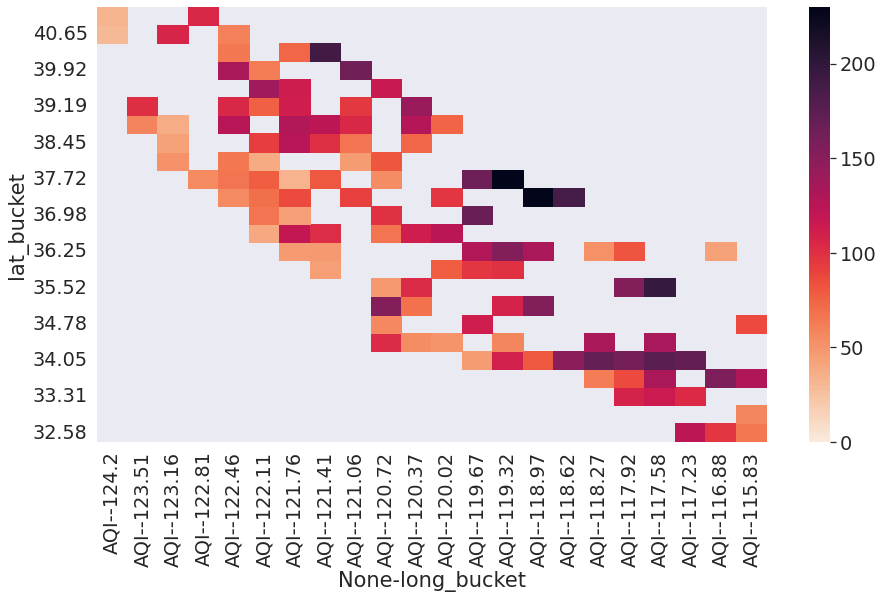

In [ ]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [ ]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    lat, lon = lat_bucket, lon_bucket
    n_rows = pivot_table.shape[0]
    n_cols = pivot_table.shape[1]
    val = pivot_table.iat[lat, lon]
    closest_cells = []
    if ~np.isnan(val):
        return val
    for a in range(lat-1, -1, -1):
        A_val = pivot_table.iat[a, lon]
        if ~np.isnan(A_val):
            closest_cells.append(A_val)
            break
    for b in range(lat+1, n_rows):
        B_val = pivot_table.iat[b, lon]
        if ~np.isnan(B_val):
            closest_cells.append(B_val)
            break
    for l in range(lon-1, -1, -1):
        L_val = pivot_table.iat[lat, l]
        if ~np.isnan(L_val):
            closest_cells.append(L_val)
            break
    for r in range(lon+1, n_cols):
        R_val = pivot_table.iat[lat, r]
        if ~np.isnan(R_val):
            closest_cells.append(R_val)
            break
    if np.size(closest_cells) >= 3:
        return np.mean(closest_cells)
    return val

In [ ]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

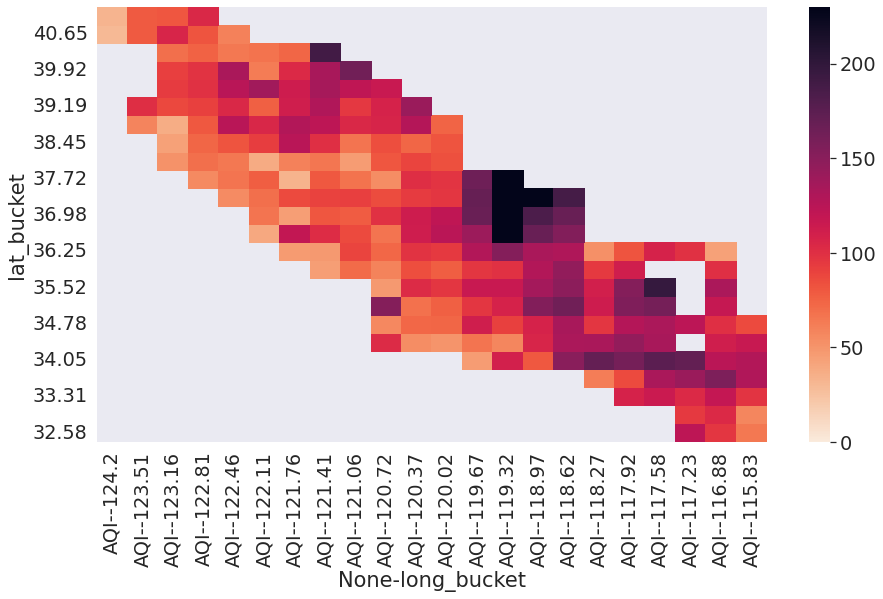

In [ ]:
def fill_all(pivot_table):
    filled = pivot_table.copy()
    n_rows = pivot_table.shape[0]
    n_cols = pivot_table.shape[1]
    for lat, lon in np.ndindex((n_rows,n_cols)):
        filled.iloc[lat, lon] = fill_bucket(pivot_table, lat, lon)
    return filled

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [ ]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

*ANS*

For a `NaN` cell, if it is located inside a triangle enclosed by three other cells, set the value of it to the average of the three cells weighted by the reciprocal of distances.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

*ANS*

We choose to use $\text{SMAPE}$ (symmetric mean absolute percentage) as the loss function for our model. The formula of SMAPE loss is as the follow where $A_t$ stands for the actual value and $P_t$ stands for the predicted value.

$${\text{SMAPE}}={\frac {1}{n}}\sum _{t=1}^{n}{\frac {\left|P_{t}-A_{t}\right|}{(|A_{t}|+|P_{t}|)/2}}$$

We decided to use this metric because it is a better metric for measuring the inaccuracy of our model, as well as the significance of this inaccuracy, which metrics such as mean squared error are not good at showing. For example, if the real AQI is 200 and the predicted one is 210, the mean squared error is 100. If the real AQI is 0 and the predicted one is 10, the mean squared error is also 100. However, it is apparent that in the latter one, the significance of this difference is larger.


<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

### External dataset
- Gas consumption: From California Energy Commission, the dataset contains the gas consumption of a county from 2016~2020. We assume that gas consumption can directly impact air quality.


- Wildfire: From California Natural Resource Agency, the dataset consists of wildfire records in California. The columns useful for us are `ALARM_DATE` and `FIRE_NUM`. We aggregate the fire that occurred on the same date together, and we can get the total number of fires on a date. We suppose that the occurrence of wildfire can greatly pollute the air.


- Climate type: From climatestotravel, they categorize counties in CA into different types: mediterranean, continental, semi-arid …etc. We hypothesize that different climate types should generally have different air quality.

- Other EPA datasets (From EPA): 

  - PM2.5: tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated
  - Barometric pressure: the pressure within the atmosphere of Earth
  - Rh_and_dewpoint: related to the humidity of the air

### Feature selection

Fixing the model type (logistic regression), we observe which combination of features can achieve the best performance.

Feature table
- Particulate: ozone, so2, co, no2, pm2.5
- Weather: temp, wind, barometric_pressure, rh_and_dewpoint
- Category: Date, state_county, climate type
- Other: gas, wildfire


We enumerate some of the feature combinations and observe which could achieve the best performance. Theoretically speaking, if we choose all the features, it can achieve the best performance. However, we can only select one particle, so we need to figure out which is the “rockstar” particle.

- Combination #1:
pm2.5 + all weather + all category + other
- Combination #2:
ozone + all weather + all category + other
- Combination #3:
so2 + all weather + all category + other
- Combination #4:
no2 + all weather + all category + other
- Combination #5:
co + all weather + all category + other

| Feature        | Training score | Testing score |
|----------------|----------------|---------------|
| Combination #1 | 0.8294         | 0.8274        |
| Combination #2 | 0.7244         | 0.7216        |
| Combination #3 | 0.7069         | 0.7034        |
| Combination #4 | 0.7077         | 0.7031        |
| Combination #5 | 0.7069         | 0.7036        |

We found that pm2.5 is the most impactful feature because it achieves the highest score in both training and testing dataset. It indicates that pm2.5 could be the dominant factor in AQI prediction.


### Model selection

Fixing the features (comb #1), we observe which models can achieve the best performance.

| model                  | train_score | test_score |
|------------------------|-------------|------------|
| LogisticRegression     |      0.8508 |     0.8231 |
| MLPClassifier          |           1 |      0.827 |
| RandomForestClassifier |      0.7128 |     0.6972 |
| KNeighborsClassifier   |           1 |     0.8094 |
| LinearRegression       |      0.7527 |     0.7424 |
| MLPRegressor           |      0.8882 |     0.7864 |
| RandomForestRegressor  |      0.9282 |      0.834 |
| KNeighborsRegressor    |      0.9995 |     0.8019 |

We select RandomForestRegressor, which has the best test_score in all of the models.

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

Features for PCA (CA 2020):
0              Longitude
1                   wind
2    barometric_pressure
3        rh_and_dewpoint
4                    gas
5          num_wildfires
dtype: object


Longitude      wind  ...  climate_mediterranean  climate_semi-arid
0  -0.680253 -0.336342  ...                      1                  0
1  -0.680253 -0.336509  ...                      1                  0
2  -0.680253 -0.337123  ...                      1                  0
3  -0.680253 -0.336421  ...                      1                  0
4  -0.680253 -0.336154  ...                      1                  0

[5 rows x 10 columns]

0    53
1    43
2    74
3    45
4    33
Name: AQI, dtype: int64

0    moderate
1        good
2    moderate
3        good
4        good
Name: Category, dtype: object

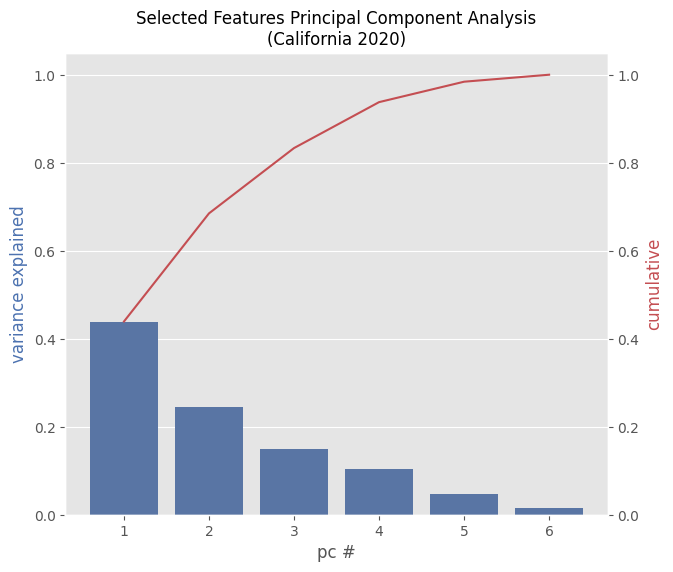

In [ ]:
from sklearn.decomposition import PCA

if colab_env:
    """
    added external datasets:
    pm2.5, barometric_pressure, rh_and_dewpoint (from EPA)
    gas (from CEC)
    climate type (from climatestotravel)
    Wildfire (from CNRA)
    """
    # download zip containing external datasets used by this project
    if not os.path.exists('data/data_extended/epa_filenames_ext.csv'):
        !pip install gdown --user --quiet
        import gdown
        extended_data_url = 'https://drive.google.com/u/1/uc?id=1e0WlafDnz-eaklHfWf7Yq3ru5zYQibGi'
        gdown.download(extended_data_url, 'data_extended.zip', False)
        with zipfile.ZipFile('data_extended.zip','r') as zip_ref:
            print('Extracting...')
            zip_ref.extractall('data')

    gc.collect()
    smape_t = lambda y, y_pred: 2*np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))

    wildfire_data = pd.read_csv('data/data_extended/California_Wildfire.csv')[['ALARM_DATE', 'CONT_DATE', 'SHAPE_Length']]
    wildfire_data = wildfire_data[wildfire_data['SHAPE_Length'] >= 10000]
    wildfire_data['ALARM_DATE'] = pd.to_datetime(wildfire_data['ALARM_DATE'], format='%Y-%m-%d', errors='coerce')
    wildfire_data['CONT_DATE'] = pd.to_datetime(wildfire_data['CONT_DATE'], format='%Y-%m-%d', errors='coerce')
    wildfire_data = wildfire_data.dropna()
    wildfire_data = wildfire_data[pd.DatetimeIndex(wildfire_data['ALARM_DATE']).year >= 2016]
    wildfire_data = wildfire_data[pd.DatetimeIndex(wildfire_data['ALARM_DATE']).year <= 2020]
    wildfire_dates = []

    for i in range(wildfire_data.shape[0]):
        wildfire_dates.extend(pd.date_range(wildfire_data.iloc[i]['ALARM_DATE'], wildfire_data.iloc[i]['CONT_DATE']))
    wildfire_count = pd.Index(wildfire_dates).value_counts()
    del wildfire_data, wildfire_dates

    def add_wildfire_count(df):
        df = df.copy()
        if not colab_env:
            # merge in dummy wildfire data if not running in colab
            # or it will take too long
            df['num_wildfires'] = np.random.normal(size=df.shape[0])
        df['num_wildfires'] = pd.to_datetime(df['Date']).apply(lambda d: wildfire_count[pd.to_datetime(d)] \
                                                              if wildfire_count.index.__contains__(d) \
                                                              else 0).astype('int')
        return df

    def pairplot_correlation(data):
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        plt.style.use('ggplot')
        plt.figure(figsize=(15, 15));
        sns.set(font_scale = 1.2);
        pp = sns.pairplot(data,
                          palette='rocket',
                          kind="reg",
                          plot_kws={'scatter_kws':{'s':2}}
                          );
        pp.fig.subplots_adjust(top=0.95);
        pp.fig.suptitle('Features Pairwise Correlation'); 

    # function to generate features, AQI targets, and AQI target category
    def build_features(cols):
        five_year_df = pd.read_csv('data/data_extended/5_years.csv')

        # filter ca 2020 data
        df_2020_CA = five_year_df[five_year_df['state_county'].str.contains(r"^6_.*") & five_year_df['Date'].str.contains(r"^2020.*")] \
                        .reset_index().drop(['index'], axis=1)
        
        # delete large df to save memory
        del five_year_df
        gc.collect()

        # add latitude, longitude, altitude
        df_2020_CA = intro_location(df_2020_CA, level='ca')

        # add month
        df_2020_CA['month'] = pd.DatetimeIndex(df_2020_CA['Date']).month

        # add fire count
        df_2020_CA = add_wildfire_count(df_2020_CA)

        # normalize
        for col in ['ozone', 'temp', 'wind',
                    'pm2.5', 'barometric_pressure',
                    'rh_and_dewpoint', 'gas', 'Latitude', 'Longitude', 'Elevation', 'num_wildfires']:
            df_2020_CA[col] = (df_2020_CA[col] - df_2020_CA[col].mean()) / (df_2020_CA[col].std())

        # filter selected columns
        df_2020_CA = df_2020_CA[cols]

        # one ht encode
        ohe_cols = ['month', 'Date', 'state_county', 'climate']
        for ohe_col in ohe_cols:
            if ohe_col in cols:
                df_2020_CA = pd.get_dummies(df_2020_CA, columns=[ohe_col])

        # generate return variables
        features = df_2020_CA.drop(['AQI', 'Category'], 1)
        targets = df_2020_CA['AQI']
        targets_cat = df_2020_CA['Category']

        # pairplot correlation
        # pairplot_correlation(features)

        return features, targets, targets_cat

    features, targets, targets_cat = build_features(['Longitude', 'wind',
                                                     'barometric_pressure', 'rh_and_dewpoint',
                                                     'gas', 'num_wildfires', 'climate',
                                                     'AQI', 'Category'])
    
    # pca
    features_pca = features.iloc[:, :6]
    print('Features for PCA (CA 2020):\n{}'.format(pd.Series(features_pca.columns)))
    my_pca = pd.DataFrame(PCA().fit(features_pca).explained_variance_ratio_, columns=['Variance Explained'])
    my_pca['Variance Explained Cumulative'] = my_pca['Variance Explained'].cumsum()

    # visualize variance explained
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot');
    plt.figure(figsize=(7, 6));
    ax = plt.subplot()
    bp = sns.barplot(ax=ax, x=my_pca.index+1, y=my_pca['Variance Explained'], color='b');
    bp.set_ylim(0, 1.05);
    bp.set_ylabel('variance explained', color='b');
    bp.set_title('Selected Features Principal Component Analysis\n(California 2020)', fontdict={'fontsize': 12});
    bp.set_xlabel('pc #');
    lp = sns.lineplot(ax=ax.twinx(), x=my_pca.index, y=my_pca['Variance Explained Cumulative'], color='r');
    lp.set_ylim(0, 1.05);
    lp.set_xlabel('pc #');
    lp.set_ylabel('cumulative', color='r');
    lp.grid(False);

else:
    """
    NOTE:
    This part makes use of traffic data, but this is not made for the report.
    Also, some visualizations are not generated here.
    It is only here to pass gradescope tests.
    """
    def lambda_county_state(x):
        return f"{x['State Code']}_{int(x['County Code']):03d}"

    # currently selected features: "ozone", "so2", "co", "no2", "temp", "wind"
    def add_features(df, features):
        df = df.copy()
        for feature in features: 
            epa_data_feature = epa_data.get(f'daily_{feature}') \
                    .rename(columns={'Date Local': 'Date', 'Arithmetic Mean': f'{feature}'})
            epa_data_feature = epa_data_feature[['State Code', 'County Code', 'Date', f'{feature}']]
            epa_data_feature['state_county'] = epa_data_feature.apply(lambda_county_state, axis=1)
            epa_data_feature = epa_data_feature.drop(['State Code', 'County Code'], 1)
            epa_data_feature = epa_data_feature.groupby(['state_county', 'Date']).mean()
            
            # normalize
            epa_data_feature[feature] = (epa_data_feature[feature] - epa_data_feature[feature].mean()) / (epa_data_feature[feature].std())
            df = df.merge(right = epa_data_feature, on = ['state_county', 'Date'])
            
        return df

    def add_AADT(df):
        df = df.copy()

        def lambda_date(x):
            return f"2020-{int(x['Month']):02d}-{int(x['Day']):02d}"

        
        gpd_epa = gpd.GeoDataFrame(epa_data_CA_merged.copy(), geometry=gpd.points_from_xy(epa_data_CA_merged.Longitude, epa_data_CA_merged.Latitude))
        gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned.copy(), geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude))

        cols = ["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", "Traffic Lat", "Traffic Long", "Descriptn", "AADT"]
        gpd_epa_traffic = gpd.sjoin_nearest(gpd_epa, gpd_traffic)
        gpd_epa_traffic = gpd_epa_traffic.rename(columns={"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", "Longitude_right": "Traffic Long"})
        gpd_epa_traffic = gpd_epa_traffic[cols]

        # filter ca data
        gpd_epa_traffic['state_county'] =  '6_' + gpd_epa_traffic['Defining Site'].str.extract(r'^\d+\-(\d+)')
        gpd_epa_traffic['Date'] = gpd_epa_traffic.apply(lambda_date, axis=1)
        cols = ['state_county', 'Date', 'AADT']
        gpd_epa_traffic = gpd_epa_traffic[cols]
        gpd_epa_traffic = gpd_epa_traffic.groupby(['state_county', 'Date']).mean()

        # normalize
        gpd_epa_traffic['AADT'] = (gpd_epa_traffic['AADT'] - gpd_epa_traffic['AADT'].mean()) / (gpd_epa_traffic['AADT'].std())
        df = df.merge(right = gpd_epa_traffic, on = ['state_county', 'Date'])
        return df

    # Join CA counties Daily AQI with co
    epa_data_CA_aqi = epa_data_CA.get("daily_county_aqi").copy()

    epa_data_CA_aqi = epa_data_CA_aqi[['County Code', 'State Code', 'Date', 'Category', 'AQI']]
    epa_data_CA_aqi['Category'] = epa_data_CA_aqi['Category'].str.lower()
    epa_data_CA_aqi['state_county'] = epa_data_CA_aqi.apply(lambda_county_state, 1)
    epa_data_CA_aqi = epa_data_CA_aqi.drop(['County Code', 'State Code'], 1)
    epa_data_CA_aqi = add_features(epa_data_CA_aqi, ['co', 'temp', 'wind'])
    epa_data_CA_aqi = add_AADT(epa_data_CA_aqi)

    epa_data_CA_aqi = pd.get_dummies(epa_data_CA_aqi, columns=["state_county", "Date"], drop_first=True)

    features = epa_data_CA_aqi.drop(['AQI', 'Category'], 1)
    targets = epa_data_CA_aqi['AQI']
    targets_cat = epa_data_CA_aqi["Category"]

display(features.head())
display(targets.head())
display(targets_cat.head())

In [ ]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [ ]:
from sklearn.base import clone
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor)
from sklearn.neighbors import (KNeighborsClassifier, KNeighborsRegressor)
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.neural_network import (MLPClassifier, MLPRegressor)

my_pca = PCA()
def pca_transform(features, num_pcs=4, fit=False):
    if fit:
        my_pca.fit(features)
    return my_pca.transform(features)[:,:num_pcs]

def build_model(features, targets, model=RandomForestRegressor(n_estimators=10, max_depth=50, criterion='mse', random_state=123), num_pcs=-1):
    if num_pcs > 0:
        features = pca_transform(features, num_pcs, True)[:,:num_pcs]
    return clone(model).fit(features, targets)

In [ ]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [ ]:
# categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
categories = ["good", "moderate", "unhealthy for sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

# we use actural mapping because we believe overestimate and underestimate are equally bad
def AQI_to_category(x):
    if x <=  50: return categories[0]
    if x <= 100: return categories[1]
    if x <= 150: return categories[2]
    if x <= 200: return categories[3]
    if x <= 300: return categories[4]
    return categories[5]

def predict(model, features, regression=True, num_pcs=-1):
    if num_pcs > 0:
        features = pca_transform(features, num_pcs)
    if regression:
        return np.array([AQI_to_category(predi) for predi in model.predict(features)])
    return model.predict(features)

In [ ]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [ ]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def cross_validate_rmse(model, X_train, y_train):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values_tr  = []
    rmse_values_val = []
    for train_idx, valid_idx in five_fold.split(X_train):
        model.fit(X_train.iloc[train_idx,:], y_train.iloc[train_idx])
        rmse_values_tr.append( rmse(y_train.iloc[train_idx], model.predict(X_train.iloc[train_idx,:])))
        rmse_values_val.append(rmse(y_train.iloc[valid_idx], model.predict(X_train.iloc[valid_idx,:])))
    return np.mean(rmse_values_tr), np.mean(rmse_values_val)

# split data
X_train, X_test, y_train, y_test, y_cat_train, y_cat_test = \
        train_test_split(features, targets, targets_cat, train_size=0.7, random_state=123)

# we compared several different model, the default model is random forest
# our actual result is generated under colab environment
# the comparison results can be found in our report
model = build_model(X_train, y_train)

# binary error
pred_cat_train = predict(model, X_train, regression=True)
pred_cat_test = predict(model, X_test, regression=True)
binary_error_train = (y_cat_train != pred_cat_train).mean()
binary_error = (y_cat_test != pred_cat_test).mean()
print('               train    test')
print('binary error  {:.4f}  {:.4f}'.format(binary_error_train, binary_error))

# the required cv error with 0.3 0.7 split
cv_error_train = np.mean(smape_t(y_train, model.predict(X_train)))
cv_error = np.mean(smape_t(y_test, model.predict(X_test)))
print('cv error      {:.4f}  {:.4f}'.format(cv_error_train, cv_error))

# the default score for models (r squared for regressors, accuracy for classifiers)
score_train = model.score(X_train, y_train)
score = model.score(X_test, y_test)
print('score         {:.4f}  {:.4f}'.format(score_train, score))

               train    test
binary error  0.1100  0.2491
cv error      0.0986  0.2169
score         0.9117  0.4542


In [ ]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

Time index length: 1827
Counties with full data: 28
['6_001' '6_007' '6_011' '6_013' '6_019' '6_037' '6_039' '6_053' '6_059'
 '6_061' '6_067' '6_069' '6_071' '6_073' '6_075' '6_077' '6_079' '6_081'
 '6_083' '6_085' '6_087' '6_095' '6_097' '6_099' '6_101' '6_103' '6_107'
 '6_113']


Category       AQI state_county  ...     long      elev  AQI_target
0      good -0.493169        6_001  ... -0.75757 -0.332373        41.0
1  moderate -0.112512        6_001  ... -0.75757 -0.332373        53.0
2  moderate  0.490195        6_001  ... -0.75757 -0.332373        72.0
3  moderate  0.141259        6_001  ... -0.75757 -0.332373        61.0
4      good -0.588333        6_001  ... -0.75757 -0.332373        38.0

[5 rows x 20 columns]

All available features:


0                Category
1                     AQI
2            state_county
3                   ozone
4                     so2
5                      co
6                     no2
7                    temp
8                    wind
9                    pm25
10    barometric_pressure
11        rh_and_dewpoint
12                    gas
13                climate
14          num_wildfires
15             time_index
16                    lat
17                   long
18                   elev
19             AQI_target
dtype: object

Global seed set to 1234
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 280   
3  | prescalers                         | ModuleDict                      | 16    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

SMAPE: 0.1481


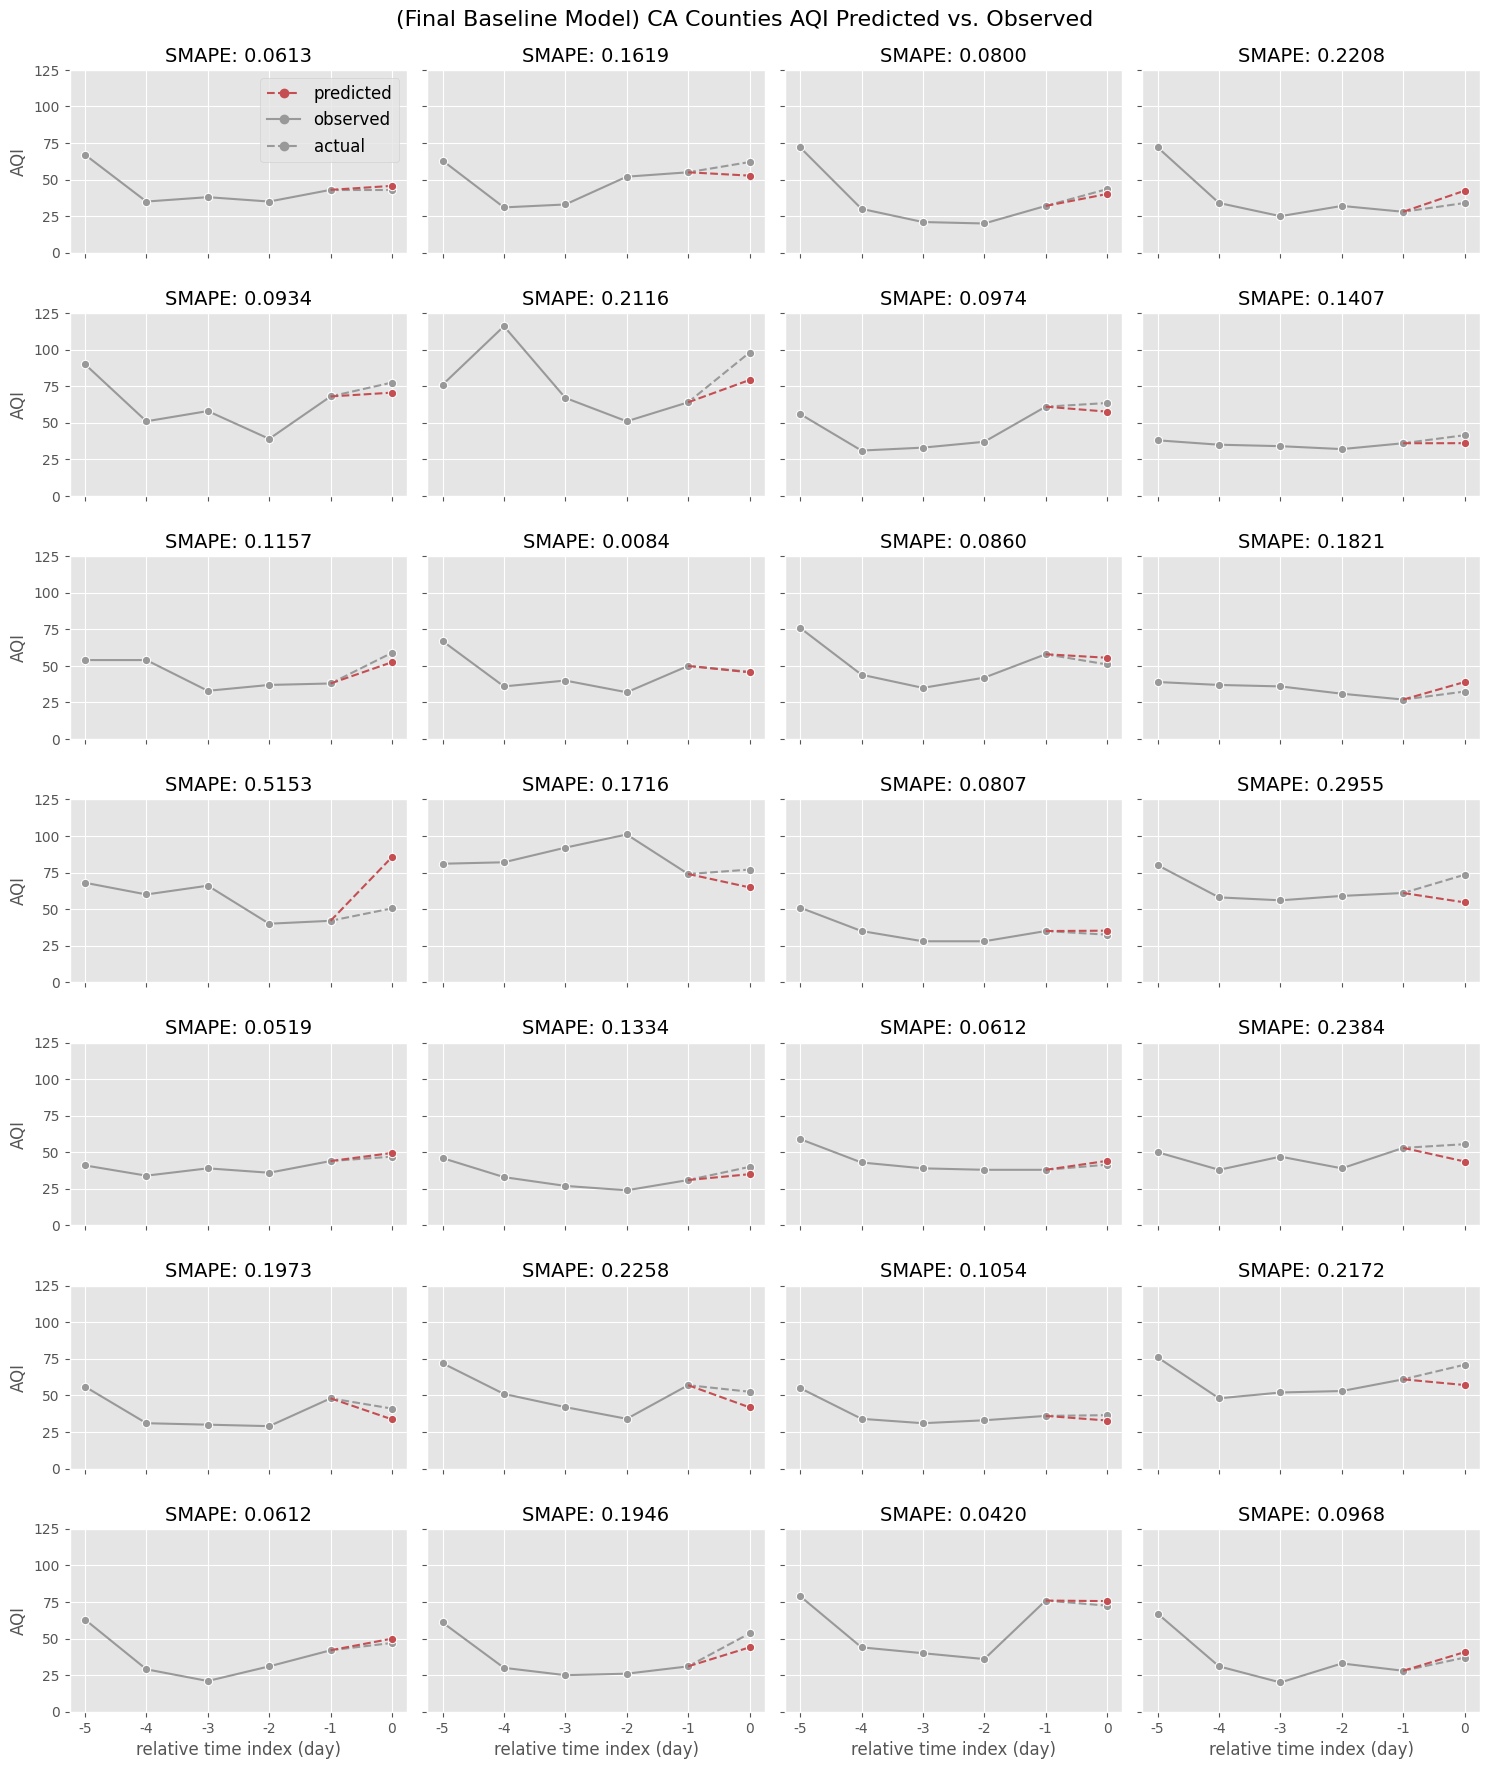

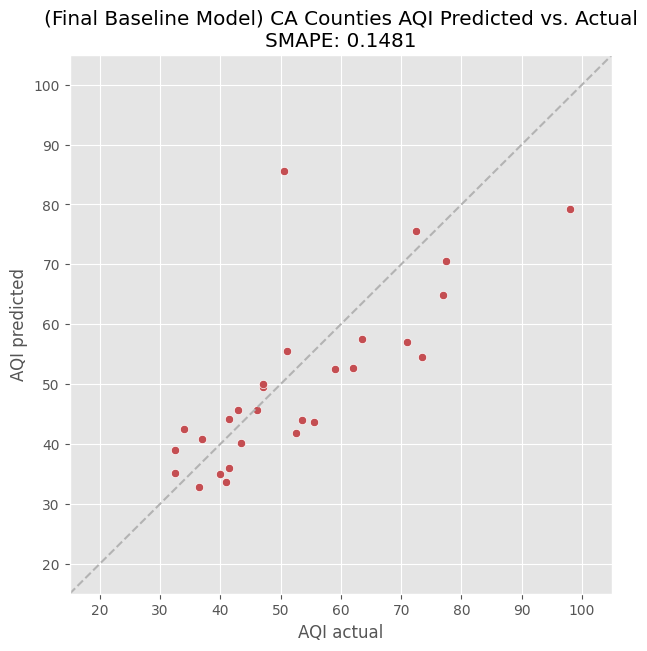

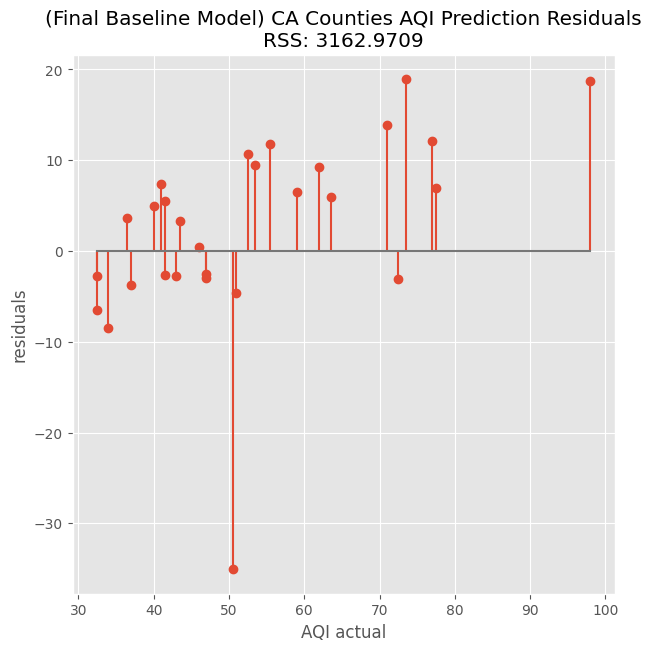

In [ ]:
gc.collect()

def create_time_index(data):
    sorted_year_day = np.sort(data['Date'].unique())
    return data['Date'].map(lambda d: np.where(sorted_year_day == d)[0][0])

def month_to_season(m):
    if ['12',  '1',  '2'].__contains__(m): return 'SP'
    if [ '3',  '4',  '5'].__contains__(m): return 'SU'
    if [ '6',  '7',  '8'].__contains__(m): return 'F'
    if [ '9', '10', '11'].__contains__(m): return 'W'
    return np.nan

# design matrix
# filter CA counties
aqi_five_years = pd.read_csv('data/data_extended/5_years.csv')
aqi_ca_five_years = aqi_five_years[aqi_five_years['state_county'].str.split('_').str[0] == '6']

# rename column for training
aqi_ca_five_years = aqi_ca_five_years.rename(columns={'pm2.5':'pm25'})

# drop counties with extreme aqi values
aqi_ca_five_years['AQI'] = aqi_ca_five_years['AQI'].apply(lambda x: x if x <= 500 else np.nan)

# filter counties having all values for each day
unique_days = aqi_ca_five_years['Date'].nunique()
print('Time index length: {}'.format(unique_days))
aqi_ca_five_years = aqi_ca_five_years.dropna().groupby('state_county') \
                .filter(lambda g: (g['Date'].nunique() == unique_days)) \
                .reset_index().drop(['index'], 1)
print('Counties with full data: {}\n{}'.format(aqi_ca_five_years['state_county'].nunique(),
                                                aqi_ca_five_years['state_county'].unique()))

# wildfire
aqi_ca_five_years = add_wildfire_count(aqi_ca_five_years)

# create time index by week
my_features = aqi_ca_five_years.copy()
my_features['time_index'] = create_time_index(my_features)

# add time-related features (currently not used)
# my_features['month'] = my_features['Date'] \
#                 .map(lambda x: pd.Period(x, freq='D').month) \
#                 .astype(str).astype("category")
# my_features['season'] = my_features['month'].apply(month_to_season)
# my_features['year'] = pd.to_datetime(my_features['Date'], format='%Y-%m-%d') \
#                 .apply(lambda x: x.strftime('%Y'))

# transformation (currently not used)
# my_features['log_AQI_mean'] = np.log(my_features['AQI_mean'] + 0.000000001)

# rename
my_features = my_features.rename(columns={
                                        #   'state_county_':'state_county',
                                        #   'gas_first':'gas',
                                          }) \
                                    .drop(['Date'], 1)

# add GEO info
my_features = intro_location(my_features, level='ca') \
                    .rename(columns={'Latitude':'lat', 'Longitude':'long', 'Elevation':'elev' })

# normalize
AQI_target = my_features['AQI'].copy()
for col in ['AQI',
            'ozone',
            'so2',
            'co',
            'no2',
            'temp',
            'wind',
            'pm25',
            'barometric_pressure',
            'rh_and_dewpoint',
            'lat', 'long', 'elev',
            'gas',
            'num_wildfires'
            ]:
    my_features[col] = (my_features[col] - my_features[col].mean()) / (my_features[col].std())
my_features['AQI_target'] = AQI_target

display(my_features.head())
print('All available features:')
display(pd.Series(my_features.columns))

all_predictions = []

forecast_data = my_features.copy()
# Temporal Fusion Transformer
training_cutoff = forecast_data['time_index'].max() - 1

training = TimeSeriesDataSet(
    forecast_data[lambda x: x.time_index <= training_cutoff],
    time_idx='time_index',
    target='AQI_target',
    group_ids=[
        'state_county'
    ],
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    static_categoricals=[
        'state_county',
        # 'climate'
    ],
    static_reals=[
        # 'lat',
        # 'long',
        # 'elev',
    ],
    time_varying_known_categoricals=[
        # 'month',
        # 'year',
        # 'season'
    ],
    variable_groups={ },
    time_varying_known_reals=[
        'time_index',
        # 'gas',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        # 'AQI',
        # 'num_wildfires',
        # 'ozone',
        # 'so2',
        # 'co',
        # 'no2',
        # 'pm25',
        # 'temp',
        # 'wind',
        # 'barometric_pressure',
        # 'rh_and_dewpoint',
    ],
    target_normalizer=GroupNormalizer(
        groups=[
            'state_county'
        ],
    ),
    predict_mode=True
)
# create validation set 
validation = TimeSeriesDataSet.from_dataset(
    training, forecast_data, predict=True, stop_randomization=True
)
# create dataloaders
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)
lr_logger = LearningRateMonitor(logging_interval='step')
logger = TensorBoardLogger('lightning_logs')

torch.manual_seed(1234)
pl.seed_everything(1234)
for i in range(5):
    gc.collect()
    # create trainer
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=int(tf.test.gpu_device_name() != ''),
        gradient_clip_val=0.4,
        limit_train_batches=30,
        callbacks=[lr_logger],
        logger=logger,
    )

    # initialize model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.05,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.3,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=0,
        reduce_on_plateau_patience=5,
    )

    # fit nn
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader
    )

    # load the best model from all epoches
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    plt.style.use('ggplot')

    # calculate smape on validation set
    y_val_tensor = torch.cat([y[0] for x, y in iter(val_dataloader)])
    y_pred_tensor = best_tft.predict(val_dataloader)
    all_predictions.append(y_pred_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1))

all_predictions.append(np.median(all_predictions, 0))
x_val = [x for x in val_dataloader][0][0].get('encoder_target')
y_val = y_val_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1)

print('SMAPE: {:.4f}'.format(smape_t(all_predictions[-1], y_val).mean()))

# visualize all nn trained
final_title = '(Baseline Model) '
for y_i in range(len(all_predictions)):
    gc.collect()
    if y_i == len(all_predictions) - 1:
        final_title = '(Final Baseline Model) '
    else:
        continue
    y_pred = all_predictions[y_i]

    # predicted vs. observed
    result_losses = smape_t(y_val, y_pred)
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    results = pd.DataFrame(np.concatenate((x_val, y_val, y_pred, result_losses), axis=1),
                        columns=['-5', '-4', '-3', '-2', '-1', '0', '0_pred', 'loss']) \
                        # .sort_values('loss')

    line_o = Line2D([0], [0], color='0.6', marker='o')
    line_a = Line2D([0], [0], color='0.6', marker='o', linestyle='--')
    line_p = Line2D([0], [0], color='r', marker='o', linestyle='--')

    fig = plt.figure(dpi=100, figsize=(15, 20))
    plt.suptitle(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    for i in range(results.shape[0]):
        ax = fig.add_subplot(results.shape[0]//4 + 1, 4, i+1);
        sns.lineplot(x=results.columns[0:5], y=results.iloc[i, 0:5],
                    color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i, 4:6],
                    linestyle='--', color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i].get(['-1', '0_pred']),
                    linestyle='--', color='r', ax=ax);
        sns.lineplot(x=results.columns[5:6], y=results.iloc[i].get(['0_pred']),
                    linestyle='--', color='r', marker='o', ax=ax);
        ax.set_title('SMAPE: {:.4f}'.format(results.iloc[i,7]), fontsize=14)
        ax.set_ylim(0, 125)
        if i%4 == 0:
            ax.set_ylabel('AQI')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if results.shape[0] - i <= 4:
            ax.set_xlabel('relative time index (day)')
        else:
            ax.set_xticklabels([])
        if i == 0:
            ax.legend([line_p, line_o, line_a],
                      ['predicted', 'observed', 'actual'],
                      fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # predicted vs. actual
    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=results['0'], y=results['0_pred'], color='r', );
    plt.plot([15, 105], [15, 105], linestyle='--', c='0.7');
    plt.xlim(15, 105);
    plt.ylim(15, 105);
    plt.xlabel('AQI actual');
    plt.ylabel('AQI predicted');
    plt.title(final_title+'CA Counties AQI Predicted vs. Actual\nSMAPE: {:.4f}'.format(np.mean(smape_t(y_val, y_pred))));

    # residuals
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.figure(figsize=(7, 7))
    plt.title(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    residuals = results['0'] - results['0_pred']
    plt.stem(results['0'], residuals, use_line_collection = True)
    plt.ylabel('residuals')
    plt.xlabel('AQI actual')
    plt.title(final_title+'CA Counties AQI Prediction Residuals\nRSS: {:.4f}'.format(np.sum(residuals**2)));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

For our model, we have decided to use a temporal fusion transformer. It relies on deep neural networks for effective forecasting. Moreover, the temporal fusion transformer allows us to extract information, which if interpreted correctly, can show us which factors contribute towards influencing the predictions. The temporal fusion transformer will utilize input data consisting of the features from 5 days to predict the AQI levels for two days in the future. The inputs to our model are the time_index and state_county features while the outputs to our model are the AQI levels of future dates. Over the span of 32 trials, we selected five random days to test our model on and computed the SMAPE error value. The mean SMAPE value we found was 0.1596, which is greater than the error threshold that we want our model to achieve in our hypothesis. (Talk about correlation coefficient also). For our future model, we first plan on first improving and optimizing the quality of the existing training data by removing any records containing the outliers found in our Principal Component Analysis from part 1 of our project. In addition, we plan on utilizing more features, especially features such as gas consumption, climate patterns, from external data sets, to improve the accuracy of our model and reduce the mean SMAPE error. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

Global seed set to 1234
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 262   
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | s

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

SMAPE: 0.1216


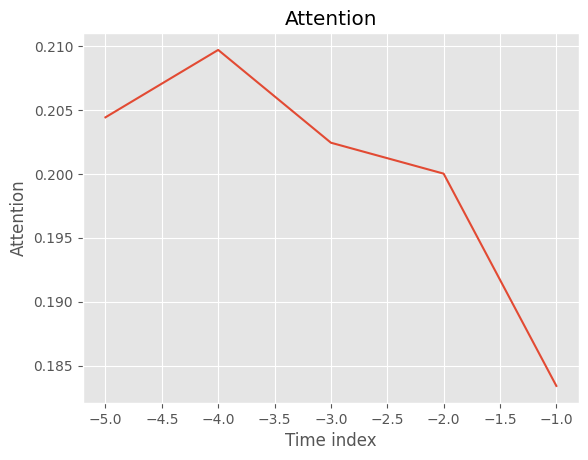

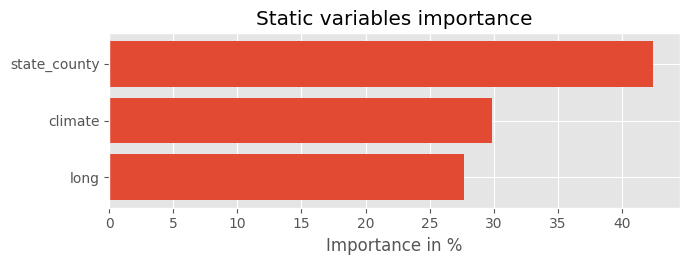

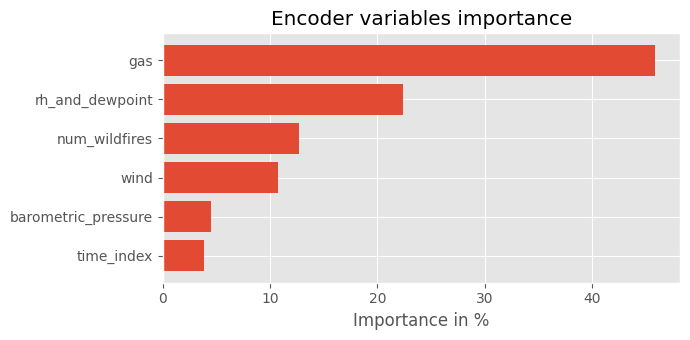

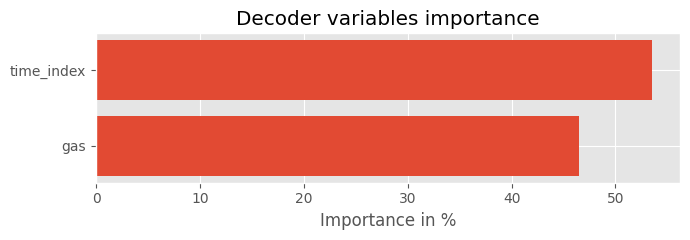

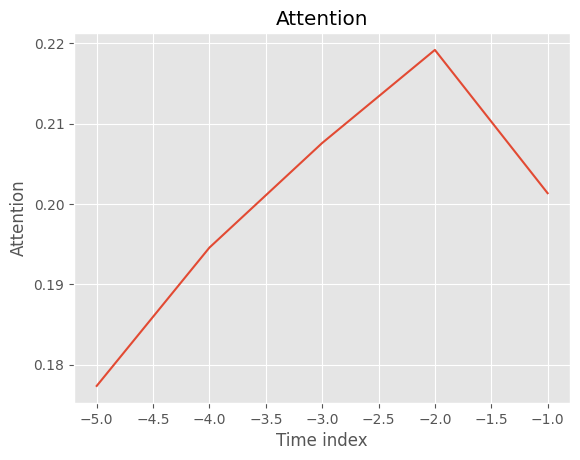

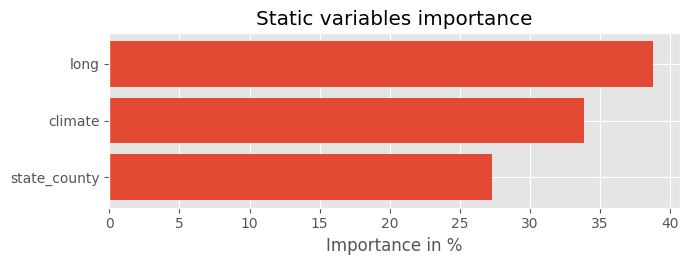

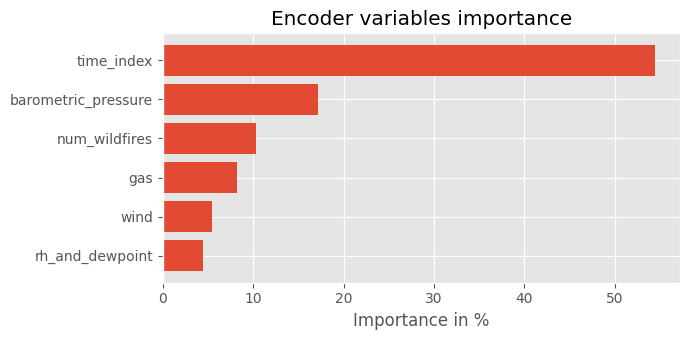

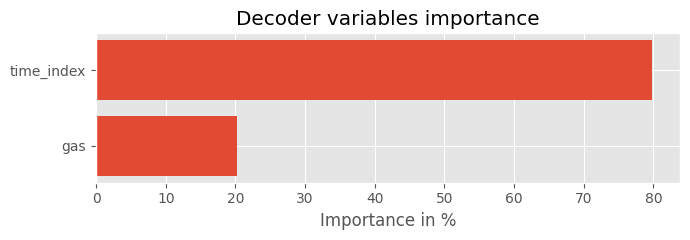

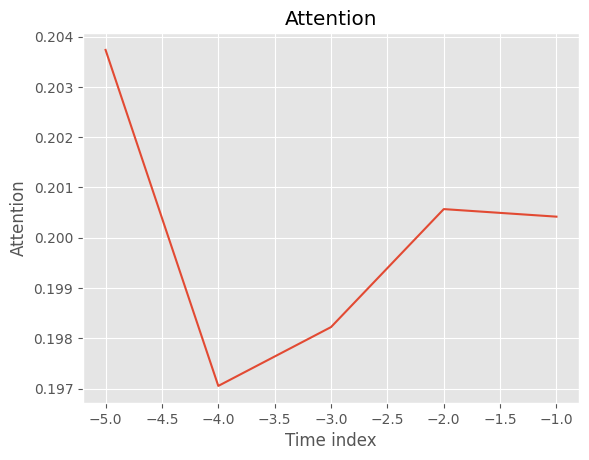

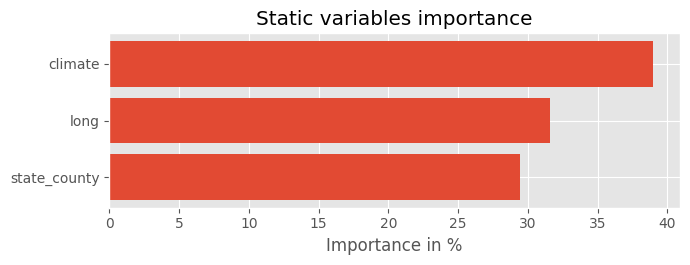

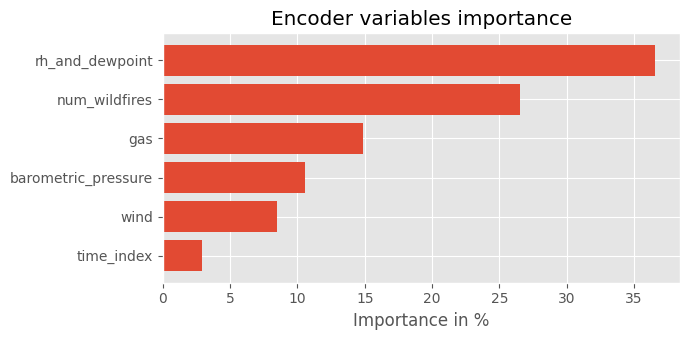

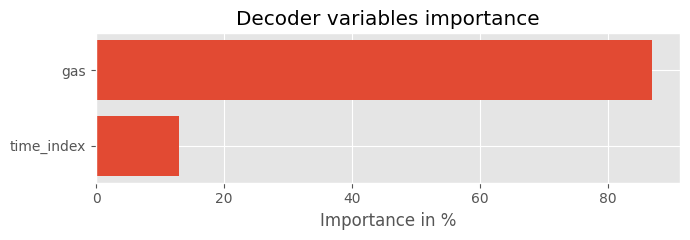

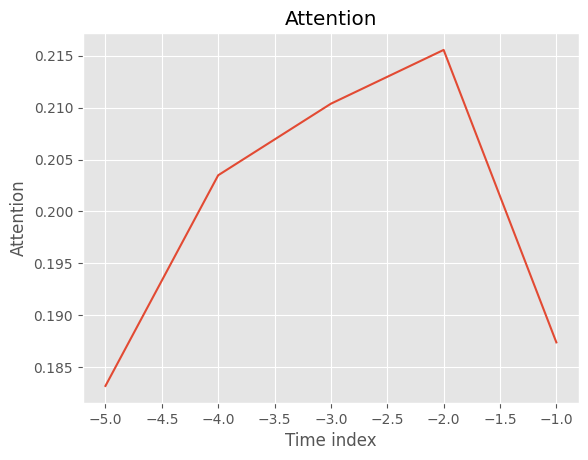

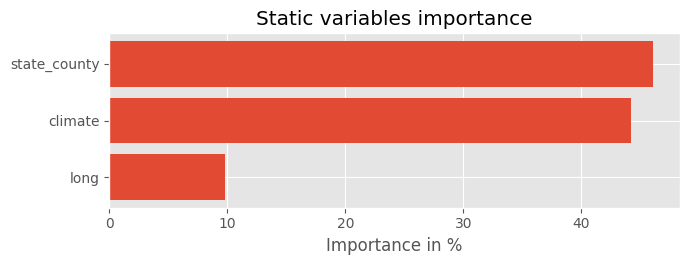

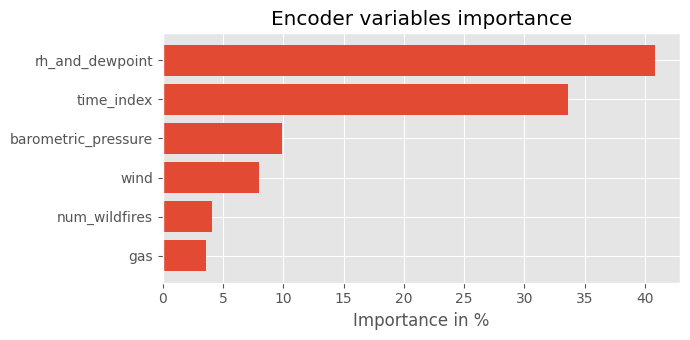

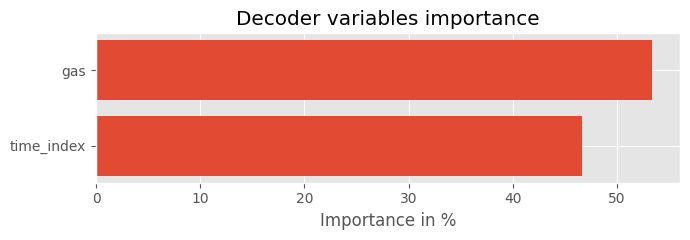

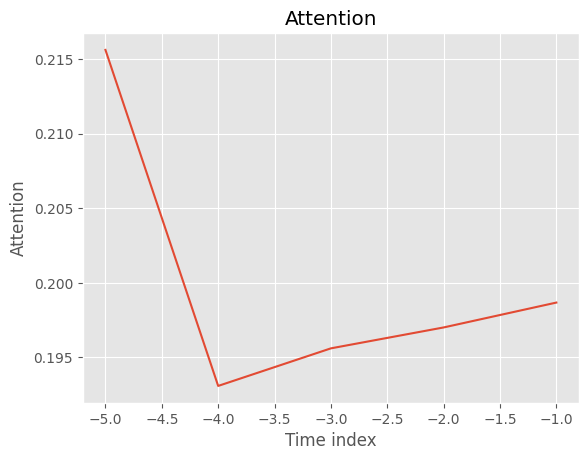

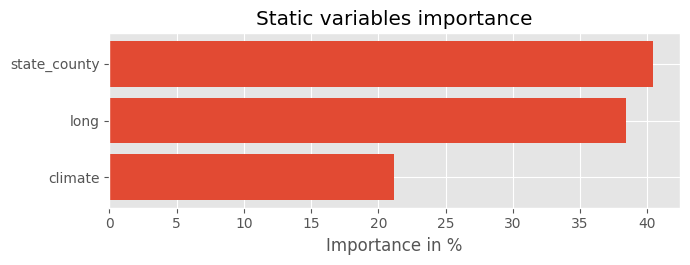

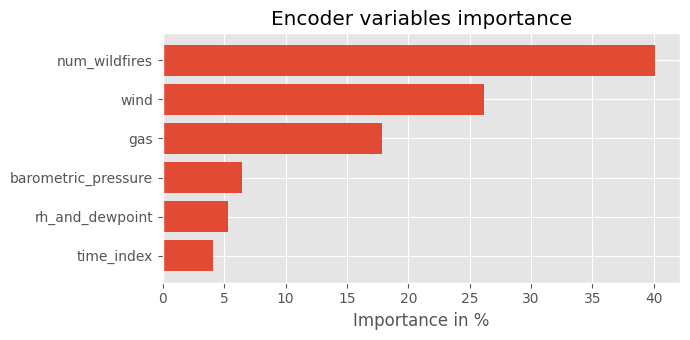

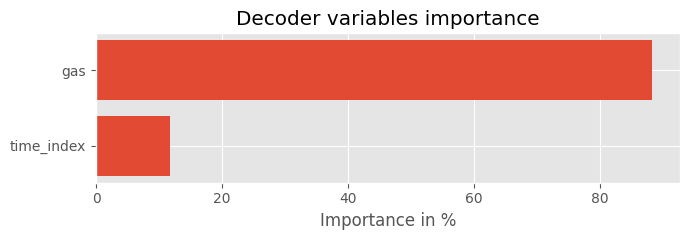

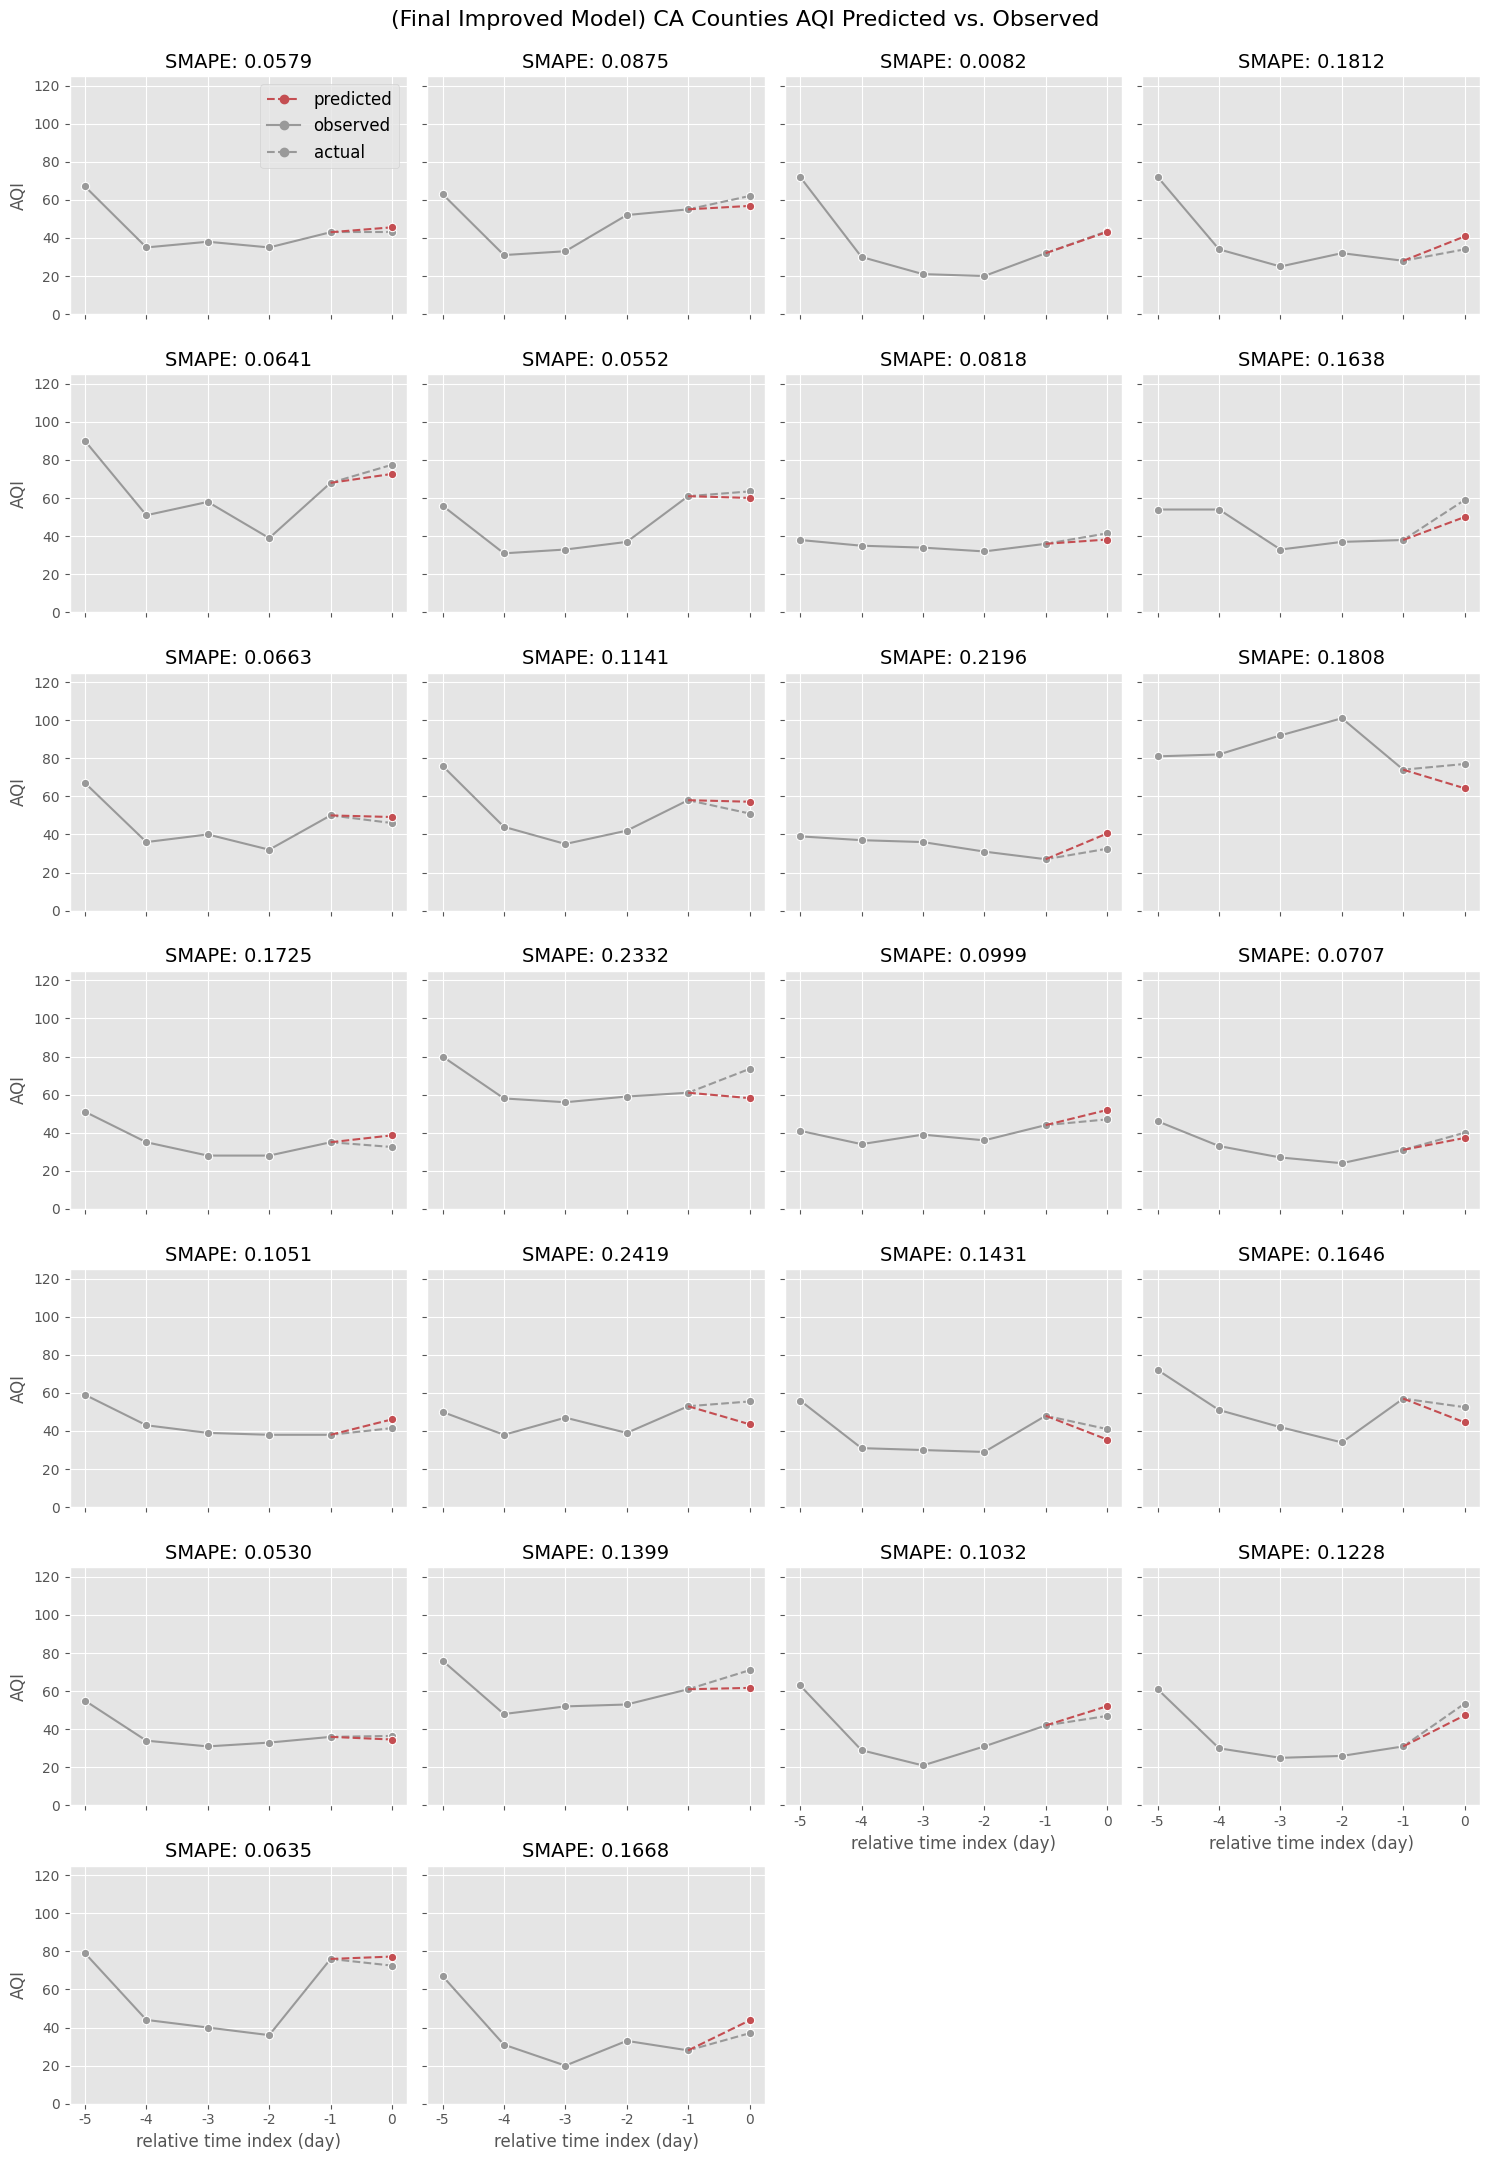

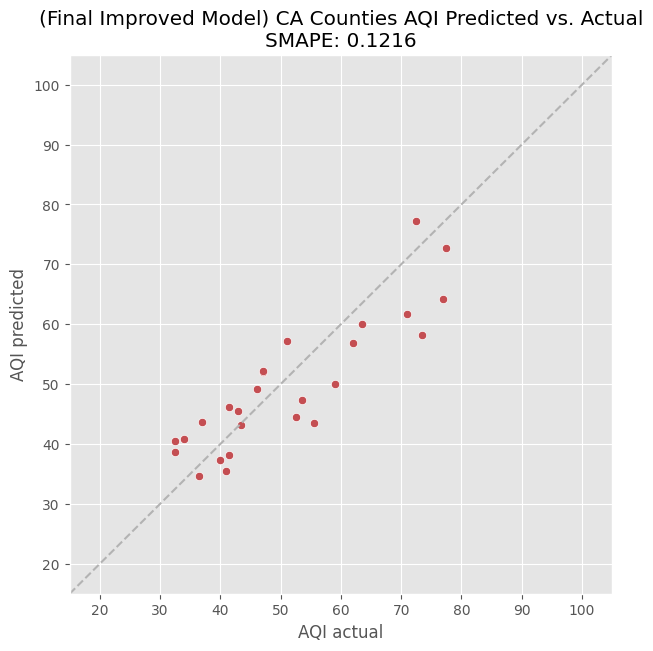

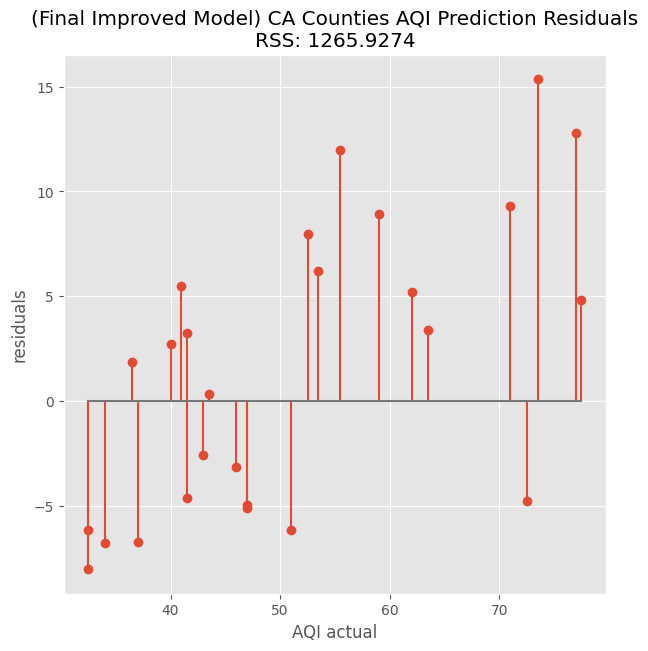

In [ ]:
# remove four outliers we identified from pca
outliers = ['6_037', '6_065', '6_051', '6_071']
my_features = my_features[~my_features['state_county'].isin(outliers)]

all_predictions = []

forecast_data = my_features.copy()
# Temporal Fusion Transformer with more features
training_cutoff = forecast_data['time_index'].max() - 1

training = TimeSeriesDataSet(
    forecast_data[lambda x: x.time_index <= training_cutoff],
    time_idx='time_index',
    target='AQI_target',
    group_ids=[
        'state_county'
    ],
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    static_categoricals=[
        'state_county',
        'climate',
    ],
    static_reals=[
        # 'lat',
        'long',
        # 'elev',
    ],
    time_varying_known_categoricals=[
        # 'month',
        # 'year',
        # 'season'
    ],
    variable_groups={ },
    time_varying_known_reals=[
        'time_index',
        'gas',
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        # 'AQI',
        'num_wildfires',
        # 'ozone',
        # 'so2',
        # 'co',
        # 'no2',
        # 'pm25',
        # 'temp',
        'wind',
        'barometric_pressure',
        'rh_and_dewpoint',
    ],
    target_normalizer=GroupNormalizer(
        groups=[
            'state_county', 
        ],
    ),
    predict_mode=True
)

# create validation set 
validation = TimeSeriesDataSet.from_dataset(
    training, forecast_data, predict=True, stop_randomization=True
)
# create dataloaders
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)
lr_logger = LearningRateMonitor(logging_interval='step')
logger = TensorBoardLogger('lightning_logs')

torch.manual_seed(1234)
pl.seed_everything(1234)
for i in range(5):
    gc.collect()
    # create trainer
    trainer = pl.Trainer(
        max_epochs=30,
        gpus=int(tf.test.gpu_device_name() != ''),
        gradient_clip_val=0.4,
        limit_train_batches=30,
        callbacks=[lr_logger],
        logger=logger,
    )

    # initialize model
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.05,
        hidden_size=32,
        attention_head_size=1,
        dropout=0.3,
        hidden_continuous_size=8,
        output_size=7,
        loss=QuantileLoss(),
        log_interval=0,
        reduce_on_plateau_patience=5,
    )

    # fit nn
    trainer.fit(
        tft,
        train_dataloader=train_dataloader,
        val_dataloaders=val_dataloader
     )

    # load the best model from all epoches
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    plt.style.use('ggplot')

    # calculate smape on validation set
    y_val_tensor = torch.cat([y[0] for x, y in iter(val_dataloader)])
    y_pred_tensor = best_tft.predict(val_dataloader)
    all_predictions.append(y_pred_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1))

    # visualize nn interpretations
    raw_predictions, _ = best_tft.predict(val_dataloader, mode='raw', return_x=True)
    interpretation = best_tft.interpret_output(
        raw_predictions, reduction="sum"
    )
    best_tft.plot_interpretation(interpretation)

all_predictions.append(np.median(all_predictions, 0))
x_val = [x for x in val_dataloader][0][0].get('encoder_target')
y_val = y_val_tensor.numpy().mean(1).reshape(y_pred_tensor.shape[0], 1)
print('SMAPE: {:.4f}'.format(smape_t(all_predictions[-1], y_val).mean()))

# visualize all nn trained
final_title = '(Improved Model) '
for y_i in range(len(all_predictions)):
    gc.collect()
    if y_i == len(all_predictions) - 1:
        final_title = '(Final Improved Model) '
    else:
        continue
    y_pred = all_predictions[y_i]

    # predicted vs. observed  
    result_losses = smape_t(y_val, y_pred)
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    results = pd.DataFrame(np.concatenate((x_val, y_val, y_pred, result_losses), axis=1),
                        columns=['-5', '-4', '-3', '-2', '-1', '0', '0_pred', 'loss']) \
                        # .sort_values('loss')

    line_o = Line2D([0], [0], color='0.6', marker='o')
    line_a = Line2D([0], [0], color='0.6', marker='o', linestyle='--')
    line_p = Line2D([0], [0], color='r', marker='o', linestyle='--')

    fig = plt.figure(dpi=100, figsize=(15, 22))
    plt.suptitle(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    for i in range(results.shape[0]):
        ax = fig.add_subplot(results.shape[0]//4 + 1, 4, i+1);
        sns.lineplot(x=results.columns[0:5], y=results.iloc[i, 0:5],
                    color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i, 4:6],
                    linestyle='--', color='0.6', marker='o', ax=ax);
        sns.lineplot(x=results.columns[4:6], y=results.iloc[i].get(['-1', '0_pred']),
                    linestyle='--', color='r', ax=ax);
        sns.lineplot(x=results.columns[5:6], y=results.iloc[i].get(['0_pred']),
                    linestyle='--', color='r', marker='o', ax=ax);
        ax.set_title('SMAPE: {:.4f}'.format(results.iloc[i,7]), fontsize=14)
        ax.set_ylim(0, 125)
        if i%4 == 0:
            ax.set_ylabel('AQI')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        if results.shape[0] - i <= 4:
            ax.set_xlabel('relative time index (day)')
        else:
            ax.set_xticklabels([])
        if i == 0:
            ax.legend([line_p, line_o, line_a],
                      ['predicted', 'observed', 'actual'],
                      fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # predicted vs. actual
    plt.figure(figsize=(7, 7))
    sns.scatterplot(x=results['0'], y=results['0_pred'], color='r');
    plt.plot([15, 105], [15, 105], linestyle='--', c='0.7');
    plt.xlim(15, 105);
    plt.ylim(15, 105);
    plt.xlabel('AQI actual');
    plt.ylabel('AQI predicted');
    plt.title(final_title+'CA Counties AQI Predicted vs. Actual\nSMAPE: {:.4f}'.format(np.mean(smape_t(y_val, y_pred))));

    # residuals
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.figure(figsize=(7, 7))
    plt.title(final_title+'CA Counties AQI Predicted vs. Observed', fontsize=16);
    residuals = results['0'] - results['0_pred']
    plt.stem(results['0'], residuals, use_line_collection = True)
    plt.ylabel('residuals')
    plt.xlabel('AQI actual')
    plt.title(final_title+'CA Counties AQI Prediction Residuals\nRSS: {:.4f}'.format(np.sum(residuals**2)));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->


The final model does seem to have better accuracy than the baseline model. After running our trials similar to how they were conducted for our baseline model, we found that mean SMAPE value to be 0.1397, which is about 2 percent lower. We were able to successfully validate our hypothesis as we were able to create a model with a mean SMAPE below 15%. We were also able to successfully build a model that is able to predict future AQI Values without usually obviously correlated features such as the air pollutant concentration levels. A research question that we were able to answer is whether the magnitude of the reduction in SMAPE warrants the use of extra external features in our model. Our conclusion to this problem is that since the reduction in SMAPE is only 2%, the use of 8 more external features cannot be justified since it can cause model complexity, run time, and space complexity to drastically increase. Our final model shows that the 2 features that our baseline model utilizes are able to have a relatively high accuracy on their own.  

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q4a results: All test cases passed!

q4i results: All test cases passed!

q5a results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q8a results: All test cases passed!

q8b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
if colab_env:
    print("Cannot export in Colab! Use DataHub instead!")
else:
    grader.export()

Cannot export in Colab! Use DataHub instead!
